In [ ]:
import numpy as np
np.random.seed(101)
import requests
import time
import joblib
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
import sklearn.metrics
import keras.models
import keras.layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
# Modelling libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Data Preprocessing

In [ ]:
df = pd.read_csv('data_kaggle.csv')

Remove properties that dont have price. isna() is the function to detect any missing data in the data frame.

In [ ]:
df = df.loc[~df["Price"].isna()]

In [ ]:
incorrect_entries = np.sum(~df["Price"].str.match(r"RM [0-9,]*$"))
print("There are {} entries in the wrong format.".format(incorrect_entries))

There are 0 entries in the wrong format.


Change the price label into numerical

In [ ]:
def strip_price(text):
    text = text.replace("RM", "")
    text = text.replace(",", "")
    text = text.strip()
    return int(text)

df["Price"] = df["Price"].apply(strip_price)
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur",1250000,2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur",6800000,6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur",1030000,3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
4,"Bukit Jalil, Kuala Lumpur",900000,4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished
5,"Taman Tun Dr Ismail, Kuala Lumpur",5350000,4+2,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished
...,...,...,...,...,...,...,...,...
53878,"Bangsar, Kuala Lumpur",5100000,5+1,4.0,NaN,Bungalow (Corner),Land area : 7168 sq. ft.,Fully Furnished
53879,"Bangsar, Kuala Lumpur",5000000,5,4.0,NaN,Bungalow (Intermediate),Land area : 15000 sq. ft.,Unfurnished
53880,"Bangsar, Kuala Lumpur",5500000,5+1,4.0,NaN,Bungalow (Intermediate),Land area : 7168 sq. ft.,Partly Furnished
53881,"Wangsa Maju, Kuala Lumpur",480000,3,2.0,NaN,Condominium (Intermediate),"Built-up : 1,150 sq. ft.",Unfurnished


Check the "Room" format

In [ ]:
sorted(df["Rooms"].unique().astype(str))

['1',
 '1+1',
 '1+2',
 '10',
 '10+',
 '10+1',
 '11',
 '11+1',
 '12',
 '12+',
 '13',
 '13+',
 '13+1',
 '14',
 '15+',
 '16',
 '18',
 '2',
 '2+1',
 '2+2',
 '20 Above',
 '3',
 '3+1',
 '3+2',
 '4',
 '4+1',
 '4+2',
 '5',
 '5+1',
 '5+2',
 '6',
 '6+',
 '6+1',
 '7',
 '7+',
 '7+1',
 '8',
 '8+',
 '8+1',
 '9',
 '9+',
 '9+1',
 'Studio',
 'nan']

Since the "Room" format is not generalizes, where some of them are string, or a, a + b, a+ integer format, we need to do futher move for them.

In [ ]:
def convert_room_num(rooms):
    try:
        if rooms.endswith("+"):
            return int(rooms[:-1])
        if re.search("[0-9]+\+[0-9]+", rooms) is not None:
            tmp = rooms.split("+")
            return int(tmp[0]) + int(tmp[1])
        if rooms == "20 Above":
            return 20
        if rooms == "Studio":
            return 1
        return int(rooms)
    except AttributeError:
        return rooms

df["Rooms"] = df["Rooms"].apply(convert_room_num)
df["Rooms"].value_counts(dropna=False)
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur",1250000,3.0,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur",6800000,6.0,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur",1030000,3.0,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
4,"Bukit Jalil, Kuala Lumpur",900000,5.0,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished
5,"Taman Tun Dr Ismail, Kuala Lumpur",5350000,6.0,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished
...,...,...,...,...,...,...,...,...
53878,"Bangsar, Kuala Lumpur",5100000,6.0,4.0,NaN,Bungalow (Corner),Land area : 7168 sq. ft.,Fully Furnished
53879,"Bangsar, Kuala Lumpur",5000000,5.0,4.0,NaN,Bungalow (Intermediate),Land area : 15000 sq. ft.,Unfurnished
53880,"Bangsar, Kuala Lumpur",5500000,6.0,4.0,NaN,Bungalow (Intermediate),Land area : 7168 sq. ft.,Partly Furnished
53881,"Wangsa Maju, Kuala Lumpur",480000,3.0,2.0,NaN,Condominium (Intermediate),"Built-up : 1,150 sq. ft.",Unfurnished


Since there's some data in Location is Uppercase and Lowercase, we generalized them all as Lowercase and remove the ", Kuala Lumpur" since all the data is in Kuala Lumpur.

In [ ]:
df["Location"] = df["Location"].str.lower()
df["Location"] = df["Location"].str.replace(r", kuala lumpur$", "", regex=True)
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,klcc,1250000,3.0,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,damansara heights,6800000,6.0,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,dutamas,1030000,3.0,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
4,bukit jalil,900000,5.0,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished
5,taman tun dr ismail,5350000,6.0,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished
...,...,...,...,...,...,...,...,...
53878,bangsar,5100000,6.0,4.0,NaN,Bungalow (Corner),Land area : 7168 sq. ft.,Fully Furnished
53879,bangsar,5000000,5.0,4.0,NaN,Bungalow (Intermediate),Land area : 15000 sq. ft.,Unfurnished
53880,bangsar,5500000,6.0,4.0,NaN,Bungalow (Intermediate),Land area : 7168 sq. ft.,Partly Furnished
53881,wangsa maju,480000,3.0,2.0,NaN,Condominium (Intermediate),"Built-up : 1,150 sq. ft.",Unfurnished


Visualize the frequency distribution where it is plotted logarithmically.

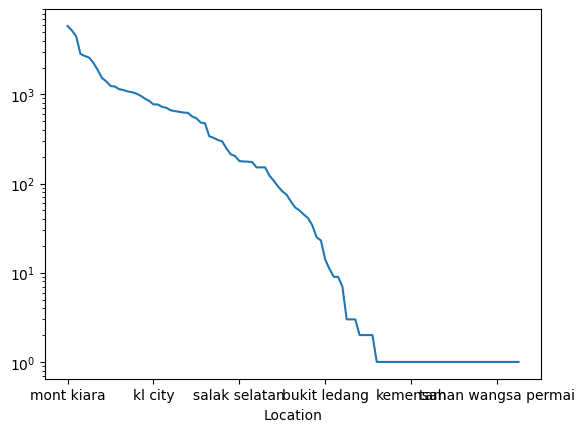

In [ ]:
df["Location"].value_counts().plot(logy=True);

Some areas has very few properties listed. This make the prediction and graph later on difficult to work with.So we need to trim the data. Locations with fewer than 100 properties listed are removed from the candidates to be analyzed.

In [ ]:
significant_locations = df["Location"].value_counts()[df["Location"].value_counts() >= 100].index
df = df.loc[np.isin(df["Location"], significant_locations)]
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,klcc,1250000,3.0,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,damansara heights,6800000,6.0,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,dutamas,1030000,3.0,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
4,bukit jalil,900000,5.0,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished
5,taman tun dr ismail,5350000,6.0,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished
...,...,...,...,...,...,...,...,...
53878,bangsar,5100000,6.0,4.0,NaN,Bungalow (Corner),Land area : 7168 sq. ft.,Fully Furnished
53879,bangsar,5000000,5.0,4.0,NaN,Bungalow (Intermediate),Land area : 15000 sq. ft.,Unfurnished
53880,bangsar,5500000,6.0,4.0,NaN,Bungalow (Intermediate),Land area : 7168 sq. ft.,Partly Furnished
53881,wangsa maju,480000,3.0,2.0,NaN,Condominium (Intermediate),"Built-up : 1,150 sq. ft.",Unfurnished


Now we check the property type

In [ ]:
df["Property Type"].value_counts()

,count
Property Type,
Condominium,11447
Serviced Residence,7176
Condominium (Corner),5687
Condominium (Intermediate),5113
Serviced Residence (Intermediate),3255
...,...
4-sty Terrace/Link House (Penthouse),1
3-sty Terrace/Link House (Triplex),1
2-sty Terrace/Link House (Penthouse),1


There are 95 property types, but since a lot of them are actually same property types, we need to do further move to merge them,

In [ ]:
def simplify_property_type(prop_type):
    super_types = [
        "Terrace/Link House", "Serviced Residence", "Condominium",
        "Semi-detached House", "Bungalow", "Apartment", "Townhouse",
        "Flat", "Residential Land", "Cluster House"]
    for super_type in super_types:
        if re.search(super_type, prop_type, flags=re.IGNORECASE) is not None:
            return super_type

    return prop_type

df["Property Type"] = df["Property Type"].apply(simplify_property_type)
df["Property Type"].value_counts()

<ipython-input-15-ddb2ab080c2d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Property Type"] = df["Property Type"].apply(simplify_property_type)


,count
Property Type,
Condominium,23149
Serviced Residence,13399
Terrace/Link House,7567
Bungalow,3598
Semi-detached House,2102
Apartment,1621
Residential Land,669
Townhouse,508
Flat,330


For Furnishing, the data is fine we dont need to clean the data

In [ ]:
df["Furnishing"].value_counts(dropna=False)

,count
Furnishing,
Partly Furnished,26222
Fully Furnished,13846
NaN,6687
Unfurnished,5611
Unknown,583


For the size feature. All the sizes is in string format.

In [ ]:
df[["Size"]]

,Size
0,"Built-up : 1,335 sq. ft."
1,Land area : 6900 sq. ft.
2,"Built-up : 1,875 sq. ft."
4,"Built-up : 1,513 sq. ft."
5,Land area : 7200 sq. ft.
...,...
53878,Land area : 7168 sq. ft.
53879,Land area : 15000 sq. ft.
53880,Land area : 7168 sq. ft.
53881,"Built-up : 1,150 sq. ft."


Because of landed area and built up are two different features, we need to split them up accordingly. Here is the function to create two new column that indicate whether this is built-up or land area.

In [ ]:
def split_size(val, index=0):
    try:
        return val.split(":")[index].strip()
    except AttributeError:
        return val

df["Size Type"] = df["Size"].apply(split_size, index=0)
df["Size Num"] = df["Size"].apply(split_size, index=1)

df["Size Type"].value_counts(dropna=False)

<ipython-input-18-3499ebcabae4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Size Type"] = df["Size"].apply(split_size, index=0)
<ipython-input-18-3499ebcabae4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Size Num"] = df["Size"].apply(split_size, index=1)


,count
Size Type,
Built-up,37493
Land area,14453
NaN,1003


Now, we need to convert Size into number type in order to do analysis.

In [ ]:
def convert_size_num(size):
    try:
        # If it is not in form of square feet simply ignore it.
        if re.search(r"sq\.*\s*ft\.*", size) is None:
            return None

        size = size.replace(",", "")
        size = size.replace("'", "")
        size = size.replace("sq. ft.", "")
        size = size.replace("sf", "")
        size = size.strip()
        size = size.lower()

        add_mult_match = re.search(r"(\d+)\s*\+\s*(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if add_mult_match is not None:
            return int(add_mult_match.groups()[0]) + (
                int(add_mult_match.groups()[1]) *
                int(add_mult_match.groups()[2]))

        mult_match = re.search(r"(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if mult_match is not None:
            return int(mult_match.groups()[0]) * int(mult_match.groups()[1])

        return int(size)
    # If none of the steps works, we simply return none. This is important because we want to make sure it is numeric.
    except:
        return None

df["Size Num"] = df["Size Num"].apply(convert_size_num)
df

<ipython-input-19-b9a1a4d4eca3>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Size Num"] = df["Size Num"].apply(convert_size_num)


,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Size Type,Size Num
0,klcc,1250000,3.0,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,Built-up,1335.0
1,damansara heights,6800000,6.0,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,Land area,6900.0
2,dutamas,1030000,3.0,4.0,2.0,Condominium,"Built-up : 1,875 sq. ft.",Partly Furnished,Built-up,1875.0
4,bukit jalil,900000,5.0,3.0,2.0,Condominium,"Built-up : 1,513 sq. ft.",Partly Furnished,Built-up,1513.0
5,taman tun dr ismail,5350000,6.0,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished,Land area,7200.0
...,...,...,...,...,...,...,...,...,...,...
53878,bangsar,5100000,6.0,4.0,NaN,Bungalow,Land area : 7168 sq. ft.,Fully Furnished,Land area,7168.0
53879,bangsar,5000000,5.0,4.0,NaN,Bungalow,Land area : 15000 sq. ft.,Unfurnished,Land area,15000.0
53880,bangsar,5500000,6.0,4.0,NaN,Bungalow,Land area : 7168 sq. ft.,Partly Furnished,Land area,7168.0
53881,wangsa maju,480000,3.0,2.0,NaN,Condominium,"Built-up : 1,150 sq. ft.",Unfurnished,Built-up,1150.0


Check the data again. Here we need the count for the data that we want and also which has missing data and data type.

In [ ]:
print("Properties with missing raw size data: {}".format(df["Size"].isna().sum()))
print("Properties with missing size type data: {}".format(df["Size Type"].isna().sum()))
print("Properties with missing size num data: {}".format(df["Size Num"].isna().sum()))

Properties with missing raw size data: 1003
Properties with missing size type data: 1003
Properties with missing size num data: 1313


synchronize the missing values between the Size Type and Size Num columns in the data frame.

In [ ]:
df.loc[df["Size Num"].isna(), "Size Type"] = None
df.loc[:, "Size Type"].value_counts(dropna=False)

,count
Size Type,
Built-up,37455
Land area,14181
None,1313


Now check the bathrooms data. It seems doesnt need any modification as it is standardized.

In [ ]:
df["Bathrooms"].value_counts(dropna=False)

,count
Bathrooms,
2.0,21163
3.0,9331
4.0,6522
5.0,4717
1.0,4482
6.0,3172
NaN,1866
7.0,1031
8.0,402


The car park data also is already standardized.

In [ ]:
df["Car Parks"].value_counts(dropna=False)

,count
Car Parks,
NaN,17042
2.0,15174
1.0,13622
3.0,3798
4.0,1913
6.0,623
5.0,501
8.0,91
10.0,76


Introduced new features from the existing parameters which are price per area and price per room. This feauture can be the new dependent variable for our model.

In [ ]:
df["Price per Area"] = df["Price"] / df["Size Num"]
df["Price per Room"] = df["Price"] / df["Rooms"]
df

<ipython-input-24-928692b6a2a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price per Area"] = df["Price"] / df["Size Num"]
<ipython-input-24-928692b6a2a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price per Room"] = df["Price"] / df["Rooms"]


,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Size Type,Size Num,Price per Area,Price per Room
0,klcc,1250000,3.0,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,Built-up,1335.0,936.329588,4.166667e+05
1,damansara heights,6800000,6.0,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,Land area,6900.0,985.507246,1.133333e+06
2,dutamas,1030000,3.0,4.0,2.0,Condominium,"Built-up : 1,875 sq. ft.",Partly Furnished,Built-up,1875.0,549.333333,3.433333e+05
4,bukit jalil,900000,5.0,3.0,2.0,Condominium,"Built-up : 1,513 sq. ft.",Partly Furnished,Built-up,1513.0,594.844679,1.800000e+05
5,taman tun dr ismail,5350000,6.0,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished,Land area,7200.0,743.055556,8.916667e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
53878,bangsar,5100000,6.0,4.0,NaN,Bungalow,Land area : 7168 sq. ft.,Fully Furnished,Land area,7168.0,711.495536,8.500000e+05
53879,bangsar,5000000,5.0,4.0,NaN,Bungalow,Land area : 15000 sq. ft.,Unfurnished,Land area,15000.0,333.333333,1.000000e+06
53880,bangsar,5500000,6.0,4.0,NaN,Bungalow,Land area : 7168 sq. ft.,Partly Furnished,Land area,7168.0,767.299107,9.166667e+05
53881,wangsa maju,480000,3.0,2.0,NaN,Condominium,"Built-up : 1,150 sq. ft.",Unfurnished,Built-up,1150.0,417.391304,1.600000e+05


In [ ]:
df.to_csv(r"Properties_preprocessed.csv")

# Data Exploration

After data preprocessing, now we can analyze the data by plotting data into graph.

In [ ]:
# This function accept feature, formatting and also factor. The factor is how can we simplify the number. For example 1e6 is 10 power of 6 which are million.
def plot_by_neighborhood(feature, formatting, factor=1):
    df_graph = df.groupby("Location")[feature].median().sort_values(ascending=False).reset_index()
    shift = 0.1 * (df_graph[feature].max() - df_graph[feature].min())
    df_sizes = df.groupby("Location").size()[df_graph["Location"]]

    fig = sns.catplot(
        data=df_graph, x=feature, y="Location", kind="bar",
        color="darkgrey", height=10, aspect=0.8)

    for index, row in df_graph.iterrows():
        fig.ax.text(
            row[feature] + shift, row.name, formatting.format(row[feature] / factor),
            color='black', ha="center", va="center")

    fig.ax.get_xaxis().set_visible(False);
    fig.despine(left=True, bottom=True)
    fig.ax.tick_params(left=False, bottom=False);
    fig.set_ylabels("");

The areas respected to the total prices in each Location

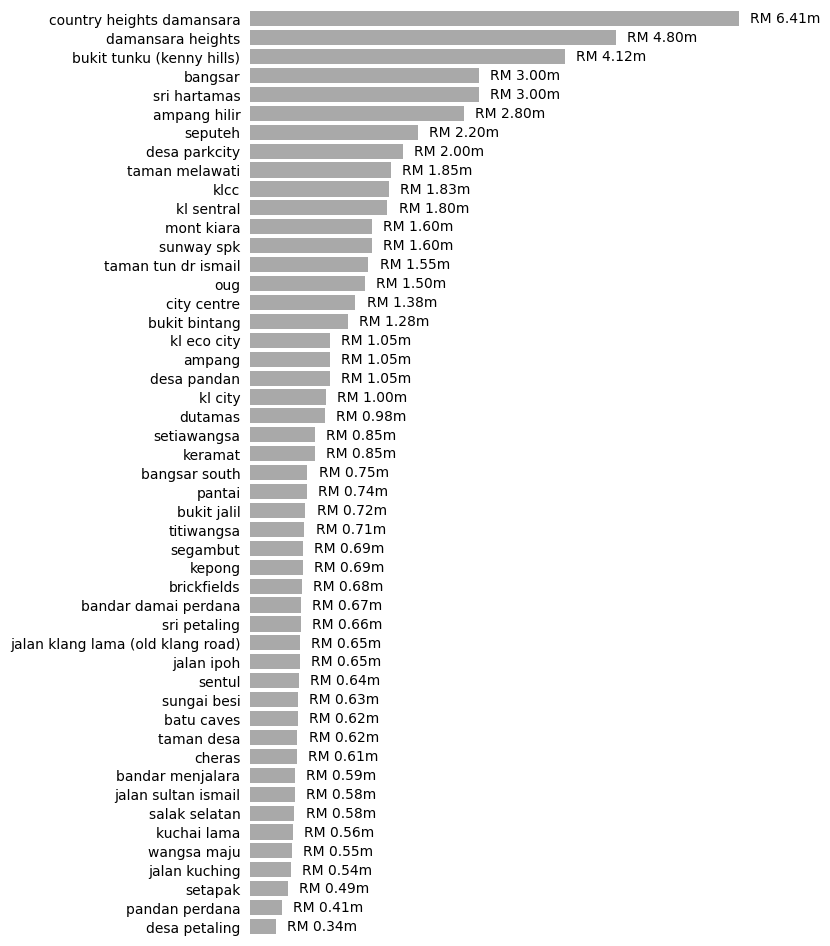

In [ ]:
plot_by_neighborhood(feature="Price", formatting="RM {:.2f}m", factor = 1e6)

The areas respected to the per square foot prices in each Location.

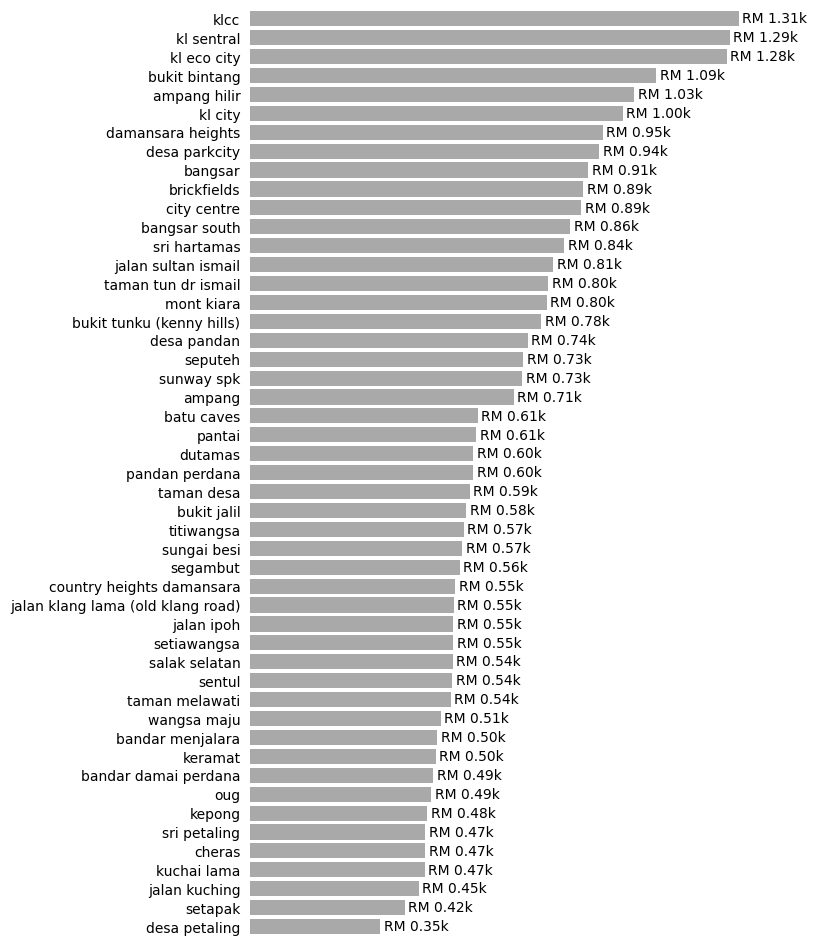

In [ ]:
plot_by_neighborhood(feature="Price per Area", formatting="RM {:.2f}k", factor = 1e3)

The areas respected to the price per room in respected location.

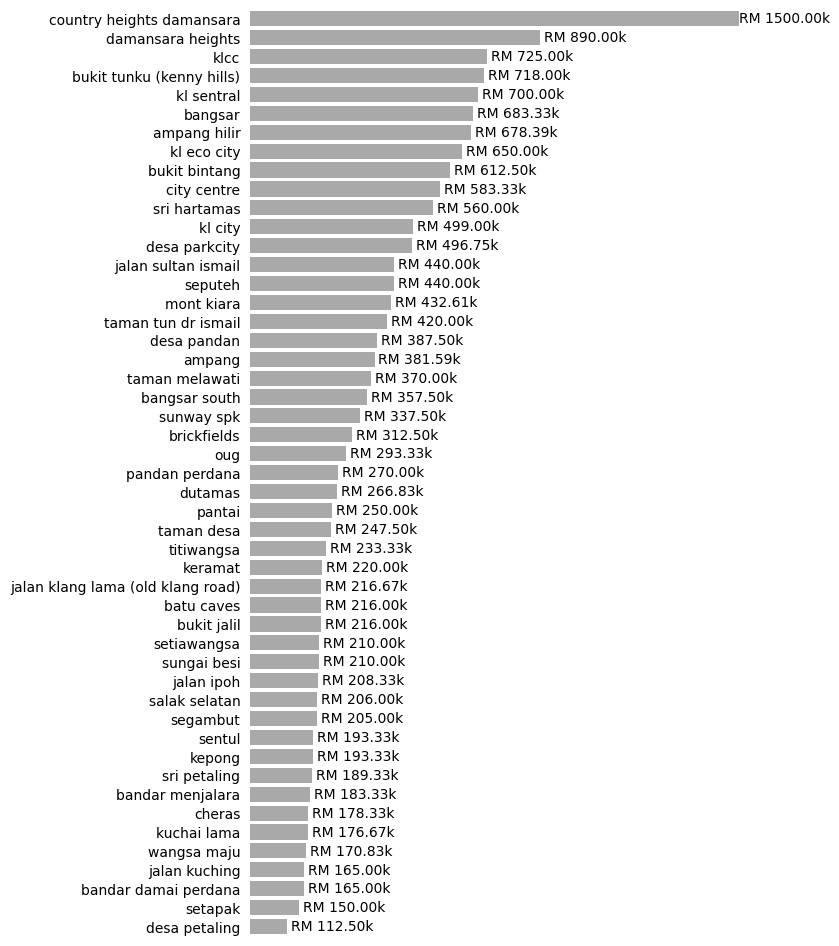

In [ ]:
plot_by_neighborhood(feature="Price per Room", formatting="RM {:.2f}k", factor = 1e3)

The Property Size per Neighborhood in respected Location.

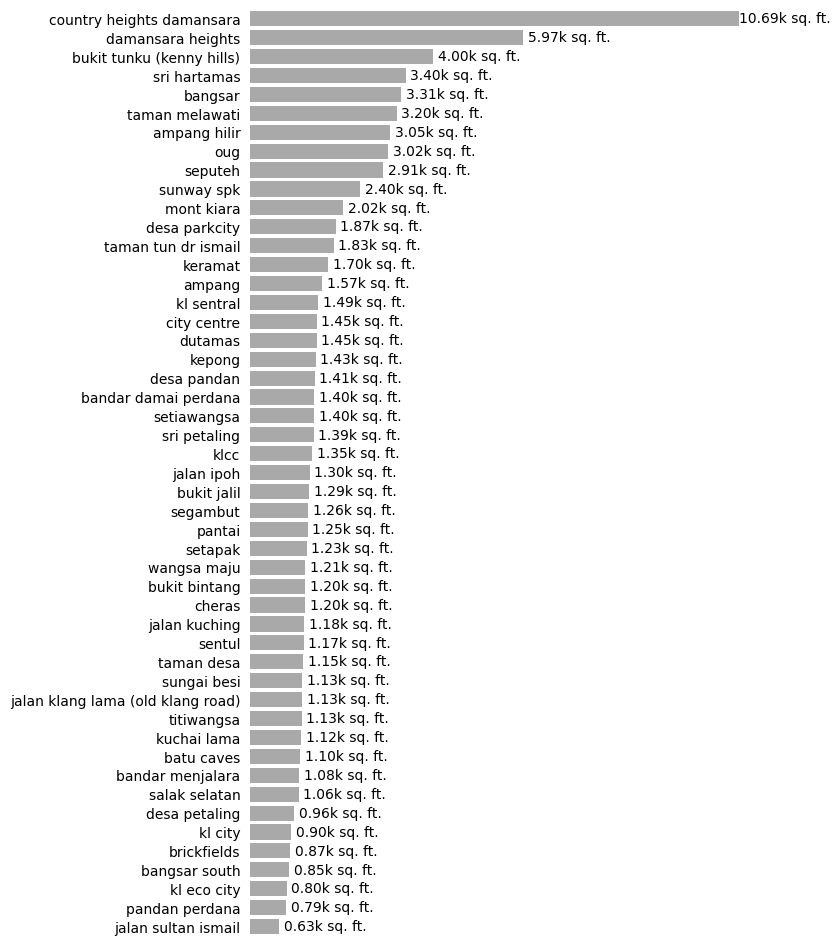

In [ ]:
plot_by_neighborhood(feature="Size Num", formatting="{:.2f}k sq. ft.", factor = 1e3)

Rooms per Neighborhood

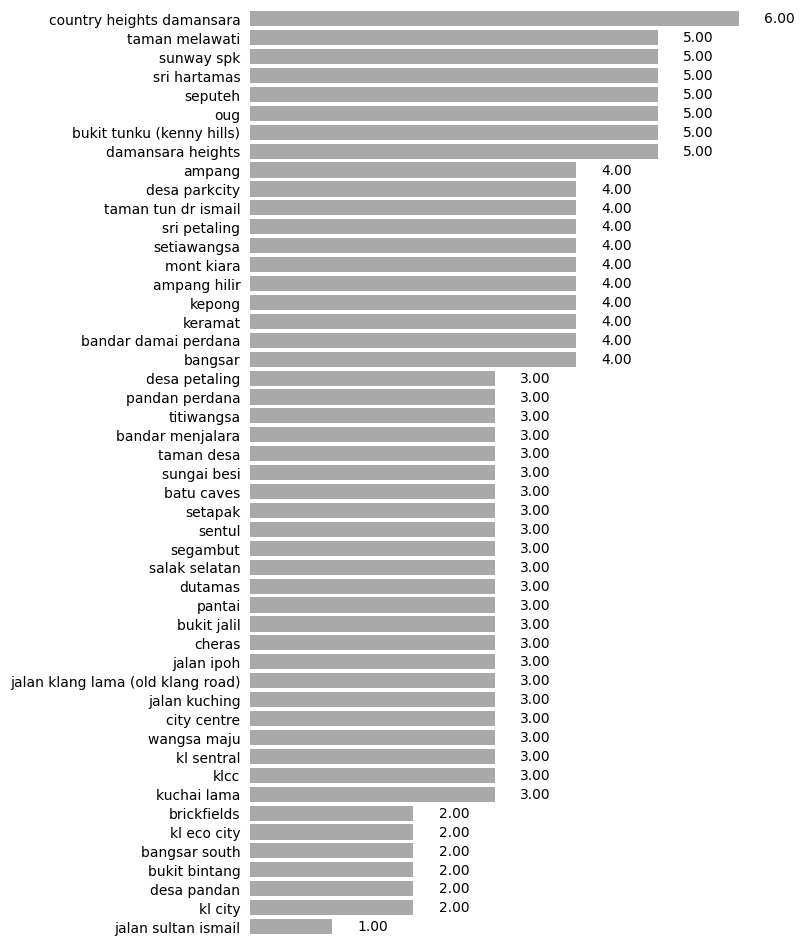

In [ ]:
plot_by_neighborhood(feature="Rooms", formatting="{:.2f}", factor = 1)

Number of Properties per Neighborhood.

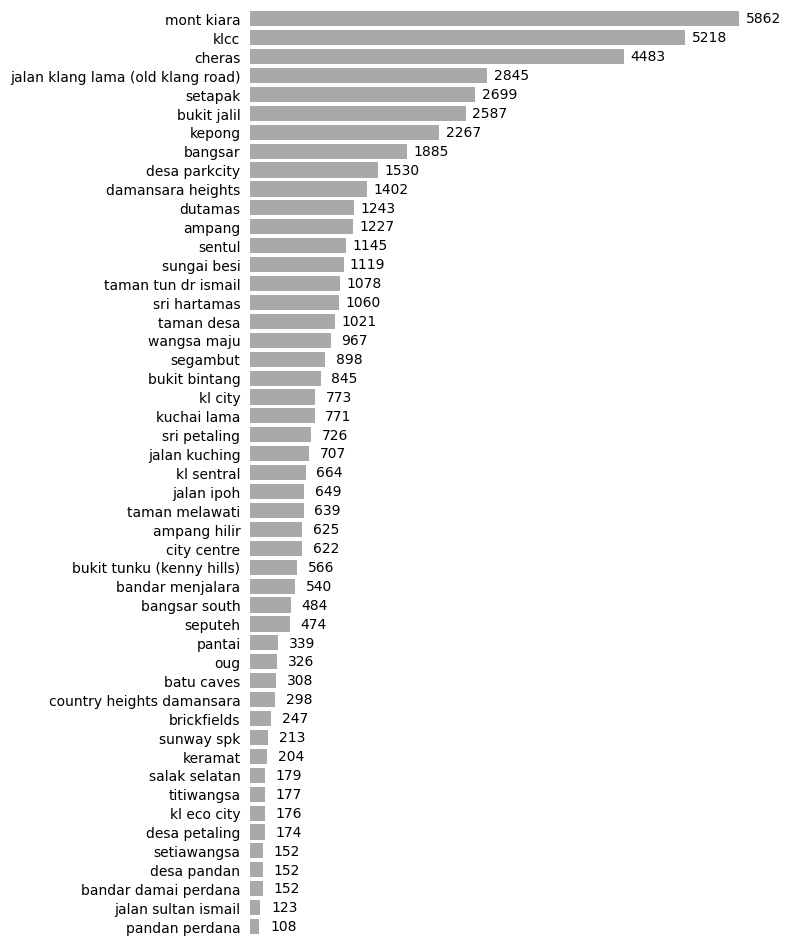

In [ ]:
properties = df.groupby("Location").size().sort_values(ascending=False).reset_index()
shift = 0.05 * (properties[0].max() - properties[0].min())
df_sizes = df.groupby("Location").size()[properties["Location"]]

fig = sns.catplot(
    data=properties, x=0, y="Location", kind="bar",
    color="darkgrey", height=10, aspect=0.8)

for index, row in properties.iterrows():
    fig.ax.text(
        row[0] + shift, row.name, row[0],
        color='black', ha="center", va="center")

fig.ax.get_xaxis().set_visible(False);
fig.despine(left=True, bottom=True)
fig.ax.tick_params(left=False, bottom=False);
fig.set_ylabels("");

Plot the heat map. This is to show the most common property type per neighborhood. The stronger the colour the more common they are.

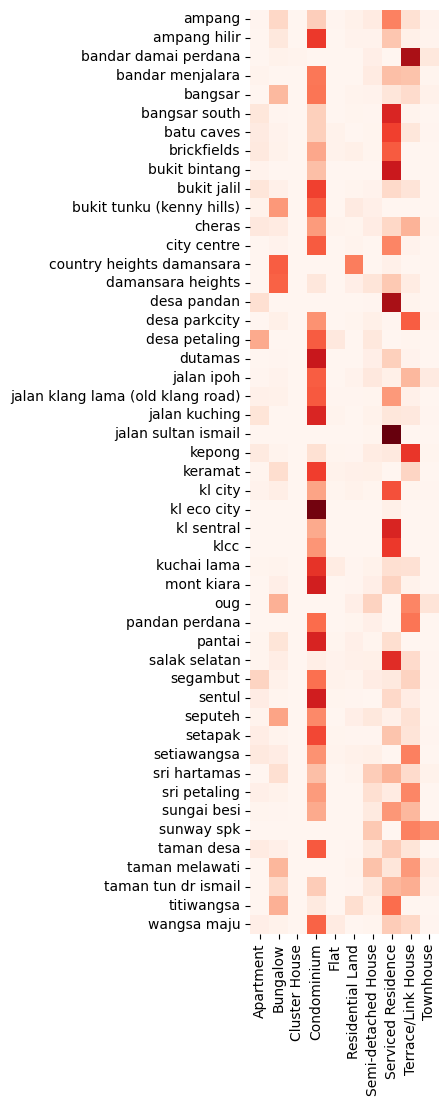

In [ ]:
# Taking the property type and putting them into a two-column data frame
properties = df.loc[~df["Property Type"].isna()].groupby(
    "Location")["Property Type"].value_counts()
properties.name = "Value"
properties = properties.reset_index().pivot(index="Location", columns="Property Type")
properties.columns = properties.columns.droplevel(0)
properties = properties.fillna(0)

# we normalize the value to see the relativity of the data
df_norm = properties.apply(lambda x: x / x.sum(), axis=1)

fix, ax = plt.subplots(figsize=(12, 12))
hmap = sns.heatmap(
    df_norm, square=True, vmin=0, cmap="Reds", ax=ax, cbar=False)
hmap.set_ylabel(None);
hmap.set_xlabel(None);

Land area and built-up are two different thing that we cannot simply compare them. So we need to know how many land area and built-up for each area. Land area vs. Built-Up Area per Neighborhood

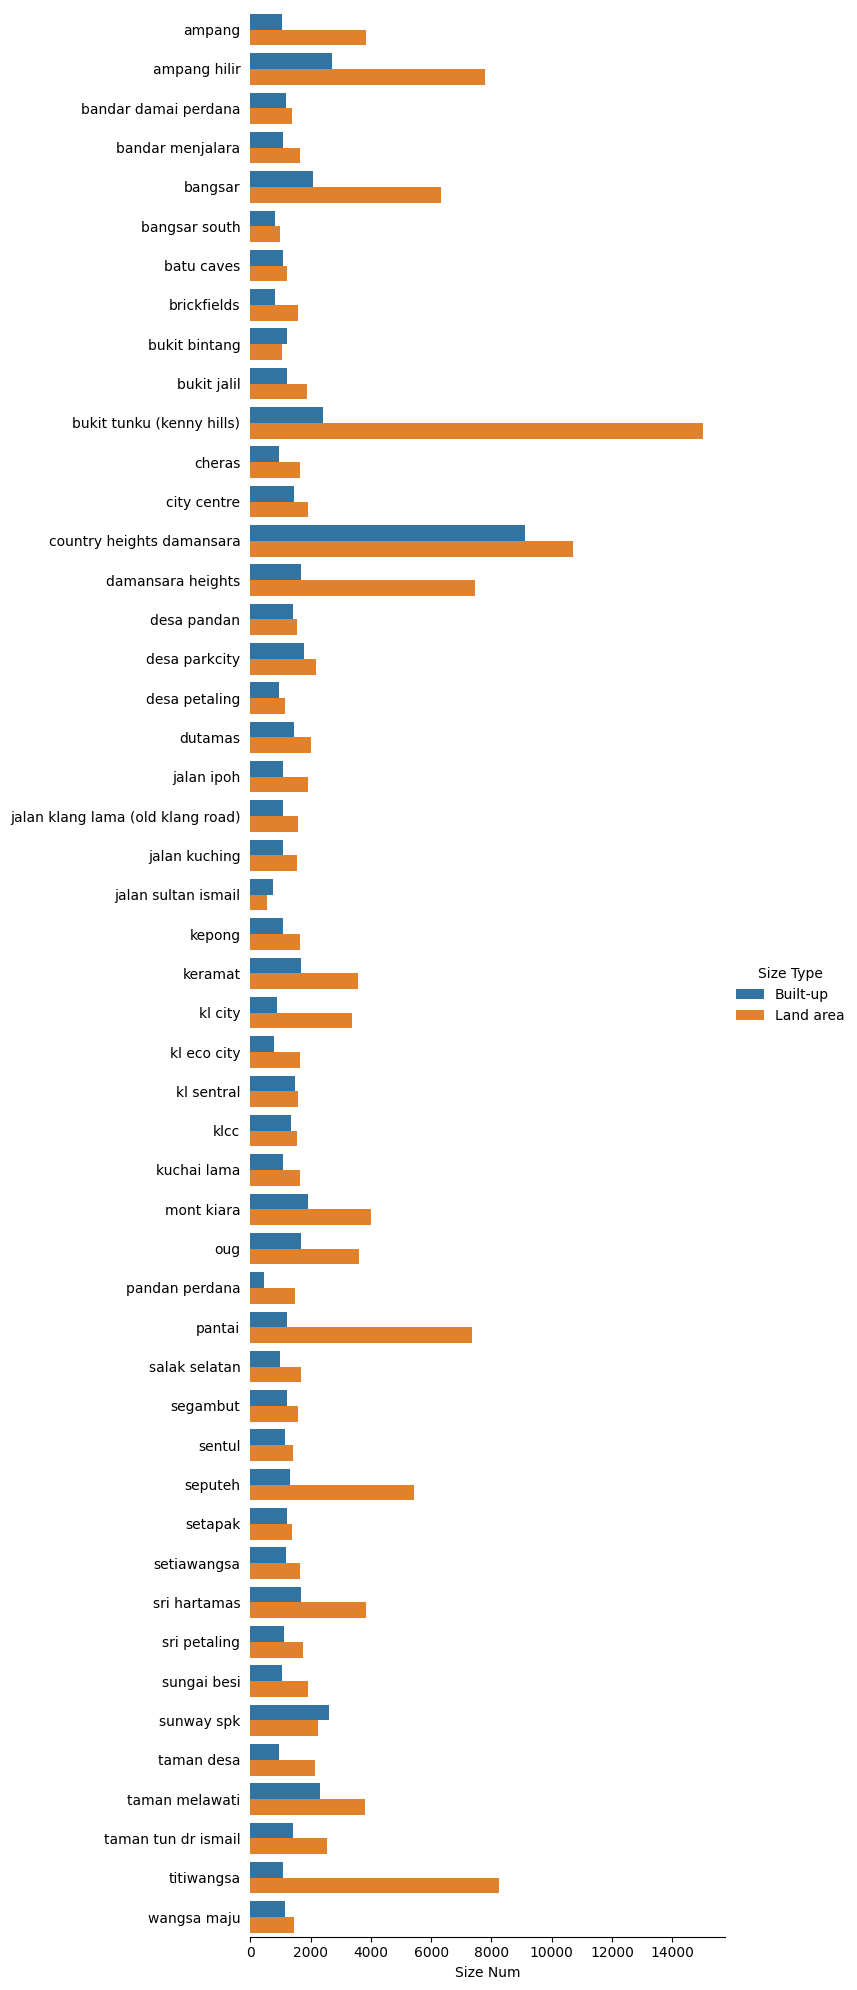

In [ ]:
properties = df[["Location", "Size Type", "Size Num"]].groupby(
    ["Location", "Size Type"]).median().reset_index()
fig = sns.catplot(
    data=properties, x="Size Num", y="Location", kind="bar",
    hue="Size Type", height=20, aspect=0.4);

fig.despine(left=True)
fig.ax.tick_params(left=False);
fig.set_ylabels("");

# Feature Processing

Here is the consideration for our data. This is done to simplify the model and gain more accurate result later on:

Only "built-up" type is considered. We cannot mix land and built up because they can cause problems in our result later on. Look only at entries without missing values for features. This means our model will only consider the following features:

Location (converted to binary dummy features)

Bathrooms， Car Parks， Furnishing (converted to binary dummy features)

Rooms (Replacing the Rooms)

Property Type Supergroup (Replacing the Property Type)

Size Num (Replacing the Size)

The model will be trained to predict three dependent variables which are the price columns, Price, Price per Area, and Price per Room.

Missing car park will be replace by 0. It might be not true but it is for the simplicity of our model. We dont make the same assumption on bathroom which should be at least one. We also remove furnishing with unknown status making it hard for the modelling.

In [ ]:
# Check and use only the available columns
available_features = [
    "Location", "Bathrooms", "Car Parks", "Furnishing",
    "Rooms", "Property Type Supergroup", "Size Num",
    "Price", "Price per Area", "Price per Room"
]
available_features = [col for col in available_features if col in df.columns]

# Filter for "Built-up" size type
Xy = df.loc[df["Size Type"] == "Built-up"]

# Keep only the selected features
Xy = Xy.loc[:, available_features]

# Replace missing car park values with zero
if "Car Parks" in Xy.columns:
    Xy["Car Parks"] = Xy["Car Parks"].fillna(0)

# Remove rows with missing values in other columns
Xy = Xy.dropna()

# Remove rows with unknown furnishing status
if "Furnishing" in Xy.columns:
    Xy = Xy.loc[Xy["Furnishing"] != "Unknown"]

# Convert categorical columns to dummy variables
Xy = pd.get_dummies(Xy)

Now lets check how the data looks. It now looks very neat for our modelling.

In [ ]:
Xy = Xy.astype({col: 'int32' for col in Xy.select_dtypes(include='bool').columns})
Xy.head()

,Bathrooms,Car Parks,Rooms,Size Num,Price,Price per Area,Price per Room,Location_ampang,Location_ampang hilir,Location_bandar damai perdana,...,Location_sungai besi,Location_sunway spk,Location_taman desa,Location_taman melawati,Location_taman tun dr ismail,Location_titiwangsa,Location_wangsa maju,Furnishing_Fully Furnished,Furnishing_Partly Furnished,Furnishing_Unfurnished
0,3.0,2.0,3.0,1335.0,1250000,936.329588,416666.666667,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4.0,2.0,3.0,1875.0,1030000,549.333333,343333.333333,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3.0,2.0,5.0,1513.0,900000,594.844679,180000.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,2.0,1.0,3.0,904.0,385000,425.884956,128333.333333,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17,7.0,0.0,6.0,4842.0,4500000,929.368030,750000.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Check the shape. It is 32413 rows(data) with 59 columns(features).

In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (32413, 59)


Check what type of data in our dataframe.

In [ ]:
print("Data frame DTYPES:")
for dtype in Xy.dtypes.unique():
    print(" - {}".format(dtype))


Data frame DTYPES:
 - float64
 - int64
 - int32


We remove Size Num outliers to improve predictions and graphs. By sorting the data, we find that the smallest reasonable size is 250 square feet, which is a small studio apartment. We use this as the lower threshold for potential values.

In [ ]:
Xy["Size Num"].sort_values().head(10)

,Size Num
7724,11.0
26309,250.0
44334,250.0
43156,250.0
23544,250.0
49397,250.0
53436,250.0
33466,250.0
42080,250.0
52309,250.0


Check the largest property sizes. Some properties are unreasonably large, like one with 820,000 square feet

In [ ]:
Xy["Size Num"].sort_values(ascending=False).head(20)

,Size Num
26310,820000.0
2437,790000.0
23507,690000.0
9339,576000.0
50850,320015.0
43550,166821.0
50824,60000.0
28733,50000.0
21072,23716.0
45085,19180.0


Heuristically set the cutoff at 20,000 square feet as the maximum and 250 square feet as the minimum.

In [ ]:
Xy = Xy.loc[Xy["Size Num"].between(250, 20000)]

We check again the shape. Should be less than previous one.

In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (32403, 59)


Trim the top and bottom 0.1% of entries from the remaining numerical columns: Bathrooms, Car Parks, and Rooms, to make the data cleaner.

In [ ]:
# Define features to filter, but only use those present in Xy
available_features = [feature for feature in ["Bathrooms", "Car Parks", "Rooms"] if feature in Xy.columns]

selectors = []
for feature in available_features:
    selectors.append(Xy[feature].between(
        Xy[feature].quantile(0.001),
        Xy[feature].quantile(0.999)))

# Combine selectors to filter outliers
Xy = Xy.loc[(~pd.DataFrame(selectors).T).sum(axis=1) == 0]


In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (32347, 59)


Feature selection will be done on a subset of the data that isn't used for training to avoid overfitting. We will use 20% of the data for testing and 80% for training.

In [ ]:
Xy, Xy_feature_selection = sklearn.model_selection.train_test_split(
    Xy, test_size=0.2, random_state=101)

Shape of data frame:

In [ ]:
Xy.shape

(25877, 59)

Shape of feature selection dataset:

In [ ]:
Xy_feature_selection.shape

(6470, 59)

3.2 Feature Scaling

First, we scale the original numerical features: Bathrooms, Car Parks, Rooms, and Size. The binary dummy features, such as Location and Furnishing, do not need scaling.

<ipython-input-48-5de3af8815bf>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=Xy_feature_selection["Size Num"], bins=50, ax=ax[1, 1], color="darkgrey");


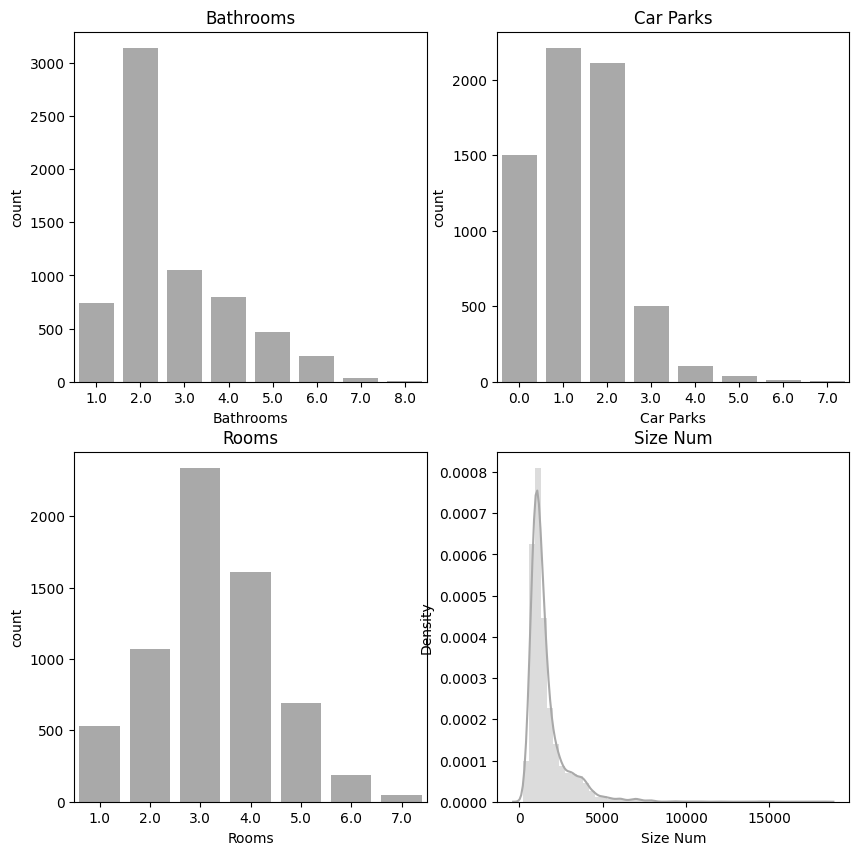

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10));
sns.countplot(data=Xy_feature_selection, x="Bathrooms", ax=ax[0, 0], color="darkgrey");
ax[0, 0].set_title("Bathrooms");
sns.countplot(data=Xy_feature_selection, x="Car Parks", ax=ax[0, 1], color="darkgrey");
ax[0, 1].set_title("Car Parks");
sns.countplot(data=Xy_feature_selection, x="Rooms", ax=ax[1, 0], color="darkgrey");
ax[1, 0].set_title("Rooms");
sns.distplot(a=Xy_feature_selection["Size Num"], bins=50, ax=ax[1, 1], color="darkgrey");
ax[1, 1].set_title("Size Num");

Since the features are not normally distributed, we'll scale them to a range of 0 to 1.

The training and feature selection datasets will be scaled separately. This step isn't crucial, but it can help improve the model's performance.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
cols = ["Bathrooms", "Car Parks", "Rooms", "Size Num"]
dump_cols = ["Car Parks", "Size Num"]

# # Save the scaer
# scaler_selected = MinMaxScaler()
# scaler_selected.fit(Xy[dump_cols])
# joblib.dump(scaler_selected, 'scaler_selected.joblib')


Xy_feature_selection[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(
    Xy_feature_selection[cols])
Xy[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(Xy[cols])


In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (25877, 59)


3.3 Feature Correlation

We dont need two data that will produce the same result for the modelling. Simply we only keep one. Now lets see the feature correlation between the independent variables (features).

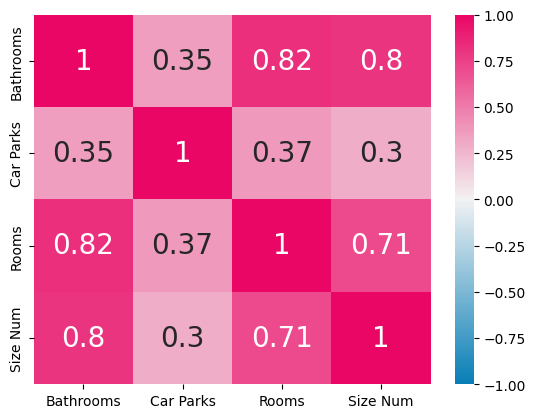

In [ ]:
hm_cmap = sns.diverging_palette(240, 0, s=99, l=50, as_cmap=True)
df = Xy_feature_selection[["Bathrooms", "Car Parks", "Rooms", "Size Num"]].corr()
sns.heatmap(data=df, vmin=-1, vmax=1, cmap=hm_cmap, annot=df, annot_kws={"size": 20});

Based on the above correlation matrix, the features Bathrooms and Rooms Num both correlate very strongly with Size Num and can be safely removed.

In [ ]:
Xy = Xy.drop(["Bathrooms", "Rooms"], axis=1, errors='ignore')
Xy_feature_selection = Xy_feature_selection.drop(["Bathrooms", "Rooms"], axis=1)

In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (25877, 57)


Now lets see the correlation of the dependent variables (features).

<Axes: >

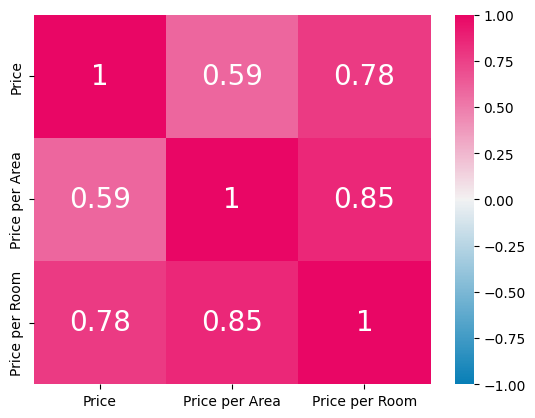

In [ ]:
df = Xy_feature_selection[["Price", "Price per Area", "Price per Room"]].corr()
sns.heatmap(
    df, vmin=-1, vmax=1, cmap=hm_cmap,
    annot=np.round(df, 2), annot_kws={"size": 20})

Price per Area and Price per Room correlate very strongly. Therefore Price per Room is removed.

In [ ]:
Xy = Xy.drop("Price per Room", axis=1)
Xy_feature_selection = Xy_feature_selection.drop("Price per Room", axis=1)

# Modelling

## Linear Regression (Multivariable)

Before we start on model training and prediction, import the processed features to .csv as checkpoint

In [ ]:
Xy.to_csv(r"BeforeModel.csv")

Then proceed to split data into training and test set. The ratio is 80% for train and 20% for test.


In [ ]:
Xy_train, Xy_test = sklearn.model_selection.train_test_split(Xy, test_size=0.2, random_state=101)
X_train = Xy_train.drop(["Price", "Price per Area"], axis=1)
y_train = Xy_train[["Price", "Price per Area"]]
X_test = Xy_test.drop(["Price", "Price per Area"], axis=1)
y_test = Xy_test[["Price", "Price per Area"]]


Lets check the data size before feeding into the model

In [ ]:
print("Shape of data Xy_train: {}".format(Xy_train.shape))
print("Shape of data Xy_test: {}".format(Xy_test.shape))
print("Shape of data X_train: {}".format(X_train.shape))
print("Shape of data y_train: {}".format(y_train.shape))

Shape of data Xy_train: (20701, 56)
Shape of data Xy_test: (5176, 56)
Shape of data X_train: (20701, 54)
Shape of data y_train: (20701, 2)


This is how the data is like.

In [ ]:
X_test.head()

,Car Parks,Size Num,Location_ampang,Location_ampang hilir,Location_bandar damai perdana,Location_bandar menjalara,Location_bangsar,Location_bangsar south,Location_batu caves,Location_brickfields,...,Location_sungai besi,Location_sunway spk,Location_taman desa,Location_taman melawati,Location_taman tun dr ismail,Location_titiwangsa,Location_wangsa maju,Furnishing_Fully Furnished,Furnishing_Partly Furnished,Furnishing_Unfurnished
17212,0.142857,0.050660,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
21972,0.285714,0.043053,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
41113,0.142857,0.029107,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17495,0.428571,0.162018,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37726,0.142857,0.060697,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Now for the prediction of prices.

In [ ]:
y_test.head()

,Price,Price per Area
17212,860000,711.331679
21972,1200000,1126.760563
41113,1350650,1686.204744
17495,3151150,950.000000
37726,1500000,1072.194425


We initialize the linear regression model

In [ ]:
linear_model = LinearRegression()

Train the model on the training data

In [ ]:
linear_model.fit(X_train, y_train["Price"])

LinearRegression()

Predict on the training set

In [ ]:
y_train_pred = linear_model.predict(X_train)

Predict on the test set

In [ ]:
y_test_pred = linear_model.predict(X_test)

Evaluate the model

In [ ]:
train_mse = mean_squared_error(y_train["Price"], y_train_pred)
test_mse = mean_squared_error(y_test["Price"], y_test_pred)

train_r2 = r2_score(y_train["Price"], y_train_pred)
test_r2 = r2_score(y_test["Price"], y_test_pred)

Print evaluation metrics

In [ ]:
print("Linear Regression Model Performance:")
print(f"Training MSE: {train_mse:.2f}, Training R-squared: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}, Test R-squared: {test_r2:.2f}")

Linear Regression Model Performance:
Training MSE: 123595074171146.64, Training R-squared: 0.02
Test MSE: 758600924158.84, Test R-squared: 0.60


The Training R-squared value (0.02) indicates that the model explains only 2% of the variance in the training data, suggesting that it is not capturing the patterns in the data well.


The Test R-squared value (0.60) indicates that the model explains 60% of the variance in the test data, which is a significant improvement over the training set.


Sample prediction comparison

In [ ]:
print("\nSample Predictions:")
comparison = y_test.copy()
comparison["Predicted Price"] = y_test_pred
print(comparison.head())


Sample Predictions:
         Price  Price per Area  Predicted Price
17212   860000      711.331679     1.339352e+06
21972  1200000     1126.760563     1.446594e+06
41113  1350650     1686.204744     1.077604e+06
17495  3151150      950.000000     3.301604e+06
37726  1500000     1072.194425     2.012828e+06


Actual price: 860,000, Predicted: ~1,339,352 (error: +479,352).
Actual price: 1,200,000, Predicted: ~1,446,594 (error: +246,594).


The predicted prices are somewhat close to the actual prices but still show significant variation.

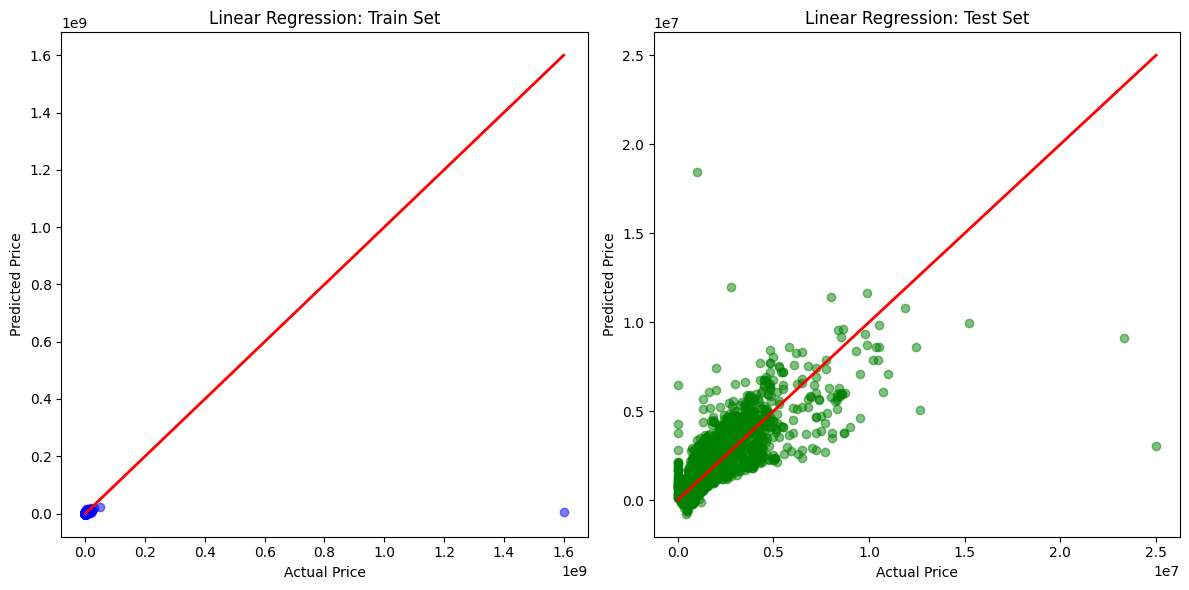

In [ ]:
# Plotting Predicted vs Actual values for the training set
plt.figure(figsize=(12, 6))

# Plot for training data
plt.subplot(1, 2, 1)
plt.scatter(y_train["Price"], y_train_pred, color='blue', alpha=0.5)
plt.plot([min(y_train["Price"]), max(y_train["Price"])],
         [min(y_train["Price"]), max(y_train["Price"])], color='red', linewidth=2)
plt.title('Linear Regression: Train Set')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Plotting Predicted vs Actual values for the test set
plt.subplot(1, 2, 2)
plt.scatter(y_test["Price"], y_test_pred, color='green', alpha=0.5)
plt.plot([min(y_test["Price"]), max(y_test["Price"])],
         [min(y_test["Price"]), max(y_test["Price"])], color='red', linewidth=2)
plt.title('Linear Regression: Test Set')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Show plots
plt.tight_layout()
plt.show()

## Hyperparameter tuning of linear regression (multivariable)

Possible causes may be due to :

i. High Variance in Price:

If prices vary greatly in the dataset, the model might struggle to fit such data with simple linear regression.
Feature-Price Relationship:

ii. Features like location and furnishing could have non-linear relationships with price, which linear regression cannot capture effectively.

iii. Outliers:

There might be outliers in the data that significantly skew the results.

iv. Feature Scaling:

Some features may require normalization or standardization for better performance

Handle Feature Scaling:

Linear regression can benefit from standardizing features to a uniform scale. We'll standardize the numerical columns while keeping dummy variables (e.g., location and furnishing) as-is.



In [ ]:
numerical_columns = ["Car Parks", "Size Num"]
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

Check for Multi-Collinearity:

Highly correlated features can cause issues with linear regression. We’ll calculate a correlation matrix and drop redundant features.



In [ ]:
correlation_matrix = X_train.corr()
high_corr_features = [col for col in correlation_matrix.columns if any(correlation_matrix[col] > 0.9) and col != correlation_matrix[col].name]
print("Highly correlated features:", high_corr_features)

Highly correlated features: []


Remove Outliers:

Outliers in price or other numerical features can skew the model. We’ll use interquartile range (IQR) or Z-scores to detect and remove outliers.

In [ ]:
X_train = X_train.drop(columns=high_corr_features)
X_test = X_test.drop(columns=high_corr_features)

Q1 = y_train["Price"].quantile(0.25)
Q3 = y_train["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (y_train["Price"] >= lower_bound) & (y_train["Price"] <= upper_bound)
X_train = X_train[outlier_mask]
y_train = y_train[outlier_mask]

Feature Selection:

Reduce dimensionality by selecting the most important features based on correlation or other criteria.


In [ ]:
selector = SelectKBest(score_func=f_regression, k=10)  # Select top 10 features
X_train = selector.fit_transform(X_train, y_train["Price"])
X_test = selector.transform(X_test)

print(f"New shape of X_train: {X_train.shape}")
print(f"New shape of X_test: {X_test.shape}")


New shape of X_train: (19004, 10)
New shape of X_test: (5176, 10)


As with the previous step, after preprocessing again, otherwise known as hyperparameter tuning we retrain the model with our new datas.

In [ ]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train["Price"])

y_train_pred = linear_model.predict(X_train)

y_test_pred = linear_model.predict(X_test)

train_mse = mean_squared_error(y_train["Price"], y_train_pred)
test_mse = mean_squared_error(y_test["Price"], y_test_pred)

train_r2 = r2_score(y_train["Price"], y_train_pred)
test_r2 = r2_score(y_test["Price"], y_test_pred)

Now we print sample predictions

In [ ]:
print("\nSample Predictions:")
comparison = y_test.copy()
comparison["Predicted Price"] = y_test_pred
print(comparison.head())


Sample Predictions:
         Price  Price per Area  Predicted Price
17212   860000      711.331679     1.046031e+06
21972  1200000     1126.760563     1.474788e+06
41113  1350650     1686.204744     1.306090e+06
17495  3151150      950.000000     2.305845e+06
37726  1500000     1072.194425     1.655208e+06


Based on sample predictions, the predicted price has gotten closer, with the first sample 17212, the price predicted has improved by 400,000, the previous error had 480,000 off, now it's only 140,000 off.

In [ ]:
print("Linear Regression Model Performance (After Preprocessing):")
print(f"Training MSE: {train_mse:.2f}, Training R-squared: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}, Test R-squared: {test_r2:.2f}")

Linear Regression Model Performance (After Preprocessing):
Training MSE: 136809720496.17, Training R-squared: 0.69
Test MSE: 841378244971.04, Test R-squared: 0.56


Although, the Training R-squared value (0.69) indicates that the model explains 69% of the variance in the training data, suggesting that it has improved in capturing the patterns in the data well.

The Test R-squared value (0.56) indicates that the model explains 56% of the variance in the test data, which is a slight deterioration.

The model exhibits a decent fit on the training data, as evidenced by the relatively low training MSE and moderate R-squared. However, the significantly higher test MSE and lower test R-squared indicate that the model might be overfitting to the training data. This means it generalizes poorly to unseen data.



In [ ]:
print("\nSample Predictions:")
# Create a DataFrame with actual and predicted prices
comparison = pd.DataFrame({
    'Actual Price': np.expm1(y_test),  # Convert back from log scale
    'Predicted Price': y_pred_test,
    'Difference': np.expm1(y_test) - y_pred_test,  # Calculate difference
    'Percent Error': abs(np.expm1(y_test) - y_pred_test) / np.expm1(y_test) * 100  # Calculate percent error
})

# Format the numbers for better readability
pd.options.display.float_format = '{:,.2f}'.format

print("\nSample Predictions (first 10 rows):")
print(comparison.head(10))

# Print some summary statistics
print("\nPrediction Summary Statistics:")
print(f"Average Absolute Error: ${comparison['Difference'].abs().mean():,.2f}")
print(f"Average Percent Error: {comparison['Percent Error'].mean():,.2f}%")
print(f"Median Percent Error: {comparison['Percent Error'].median():,.2f}%")


Sample Predictions:


/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: overflow encountered in expm1
  result = func(self.values, **kwargs)


NameError: name 'y_pred_test' is not defined

In [ ]:
# Plotting the predictions
plt.figure(figsize=(10, 6))

# Plot actual vs predicted values for training set
plt.subplot(1, 2, 1)
plt.scatter(y_train["Price"], y_train_pred, color='blue', alpha=0.5)
plt.plot([min(y_train["Price"]), max(y_train["Price"])], [min(y_train["Price"]), max(y_train["Price"])], color='red', linestyle='--')
plt.title('Train: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Plot actual vs predicted values for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test["Price"], y_test_pred, color='green', alpha=0.5)
plt.plot([min(y_test["Price"]), max(y_test["Price"])], [min(y_test["Price"]), max(y_test["Price"])], color='red', linestyle='--')
plt.title('Test: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize the Ridge regression model
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization strength

# Train the model
ridge_model.fit(X_train, y_train["Price"])

# Make predictions on train and test sets
y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)

# Calculate MSE and R-squared
train_mse_ridge = mean_squared_error(y_train["Price"], y_train_pred_ridge)
test_mse_ridge = mean_squared_error(y_test["Price"], y_test_pred_ridge)

train_r2_ridge = r2_score(y_train["Price"], y_train_pred_ridge)
test_r2_ridge = r2_score(y_test["Price"], y_test_pred_ridge)

# Print evaluation metrics
print("Ridge Regression Model Performance:")
print(f"Training MSE: {train_mse_ridge:.2f}, Training R-squared: {train_r2_ridge:.2f}")
print(f"Test MSE: {test_mse_ridge:.2f}, Test R-squared: {test_r2_ridge:.2f}")


## Decision Tree

As linear regression face the issue of overfitting, we now explore non-linear models, which one of them being decision tree.

First we initialize decision tree model, note that it has 10 depths

In [ ]:
tree_model = DecisionTreeRegressor(max_depth=10, random_state=101)

Fitting the model on training data

In [ ]:
tree_model.fit(X_train, y_train["Price"])
y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

To evaluate model we will use MSE and R2 score

In [ ]:
train_mse = mean_squared_error(y_train["Price"], y_train_pred)
test_mse = mean_squared_error(y_test["Price"], y_test_pred)

train_r2 = r2_score(y_train["Price"], y_train_pred)
test_r2 = r2_score(y_test["Price"], y_test_pred)


Now we print evaluation metrics

In [ ]:
print("Decision Tree Model Performance:")
print(f"Training MSE: {train_mse:.2f}, Training R-squared: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}, Test R-squared: {test_r2:.2f}")

Decision Tree Model Performance:
Training MSE: 92445948368.29, Training R-squared: 0.79
Test MSE: 1126458337447.12, Test R-squared: 0.41


The model exhibits a good fit on the training data, as evidenced by the relatively low training MSE and high R-squared. However, the significantly higher test MSE and lower test R-squared indicate that the model might be overfitting to the training data. This means it generalizes poorly to unseen data.

In [ ]:
print("\nSample Predictions:")
comparison = y_test.copy()
comparison["Predicted Price"] = y_test_pred
print(comparison.head())


Sample Predictions:
         Price  Price per Area  Predicted Price
17212   860000      711.331679     8.587475e+05
21972  1200000     1126.760563     1.200000e+06
41113  1350650     1686.204744     1.734873e+06
17495  3151150      950.000000     2.688795e+06
37726  1500000     1072.194425     1.317579e+06


Thru observations, we see close predictnios, suggesting good model accuracy in these cases, however overestimated prices in some instances indicates that the model might be overestimating or underestimating prices for certain property characteristics.

## Hyperparameter tuning of Decision Tree

Possible Causes of Overfitting:

i. Model Complexity: Decision trees can be prone to overfitting, especially if they are allowed to grow too deep.

ii. Feature Engineering: The preprocessing steps might have introduced noise or irrelevant features.

iii. Complex Relationships: The relationship between "Price per Area" and "Price" might not be perfectly linear or captured by the decision tree model's structure.


So we will tune the paramters of decision tree, starting with depth, splits and nodes.

In [ ]:
param_grid = {
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

Re-initialize decision tree model

In [ ]:
tree_model = DecisionTreeRegressor(random_state=101)

Performing grid search's tuning
Also this step is crucial as it finds the best settings for parameters


In [ ]:
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    verbose=1,
    n_jobs=-1
)

And fitting the model for training the new decision tree

In [ ]:
grid_search.fit(X_train, y_train["Price"])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=101), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2', verbose=1)

These are the best paramters and model

In [ ]:
best_params = grid_search.best_params_
best_tree_model = grid_search.best_estimator_

print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


Now we are able to evalute the best model on test data

In [ ]:
y_test_pred = best_tree_model.predict(X_test)
test_mse = mean_squared_error(y_test["Price"], y_test_pred)
test_r2 = r2_score(y_test["Price"], y_test_pred)

print("Optimized Decision Tree Performance:")
print(f"Test MSE: {test_mse:.2f}, Test R-squared: {test_r2:.2f}")

Optimized Decision Tree Performance:
Test MSE: 1047033588373.35, Test R-squared: 0.45


The results indicate an improvement in the Test R-squared after hyperparameter tuning (from 0.41 to 0.45), along with a reduction in Test MSE (from 1126458337447.12 to 1047033588373.35). This suggests that the optimized decision tree is better at generalizing to unseen data.

In [ ]:
y_test_pred = best_tree_model.predict(X_test)

comparison = y_test.copy()
comparison["Predicted Price"] = y_test_pred

print("Sample Predictions (After Hyperparameter Tuning):")
print(comparison.head())

Sample Predictions (After Hyperparameter Tuning):
         Price  Price per Area  Predicted Price
17212   860000      711.331679     8.325000e+05
21972  1200000     1126.760563     1.242857e+06
41113  1350650     1686.204744     1.613657e+06
17495  3151150      950.000000     2.769050e+06
37726  1500000     1072.194425     1.526700e+06


Training Performance vs. Test Performance:

In the old model, the training R-squared was 0.79, significantly higher than the test R-squared (0.41). This discrepancy indicates overfitting.
After hyperparameter tuning, the model's performance on test data improved, reducing overfitting.

The predicted prices are closer to the true values after tuning, particularly for some outlier data points.

## Random Forest

As R-squared and MSE are unsatisfactory for application, we will consider ensembling methods like Random Forest. As this also mitigates overfitting seen in a single decision tree.

Random Forest is an ensemble learning method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting.

We start by initializing the model as like the rest.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=101)

We will have 100 output/estimators and a max depth of 15 each.

And now we train our model.

In [ ]:
rf_model.fit(X_train, y_train["Price"])

y_train_pred = rf_model.predict(X_train)

y_test_pred = rf_model.predict(X_test)

After training the model, we will evaluate the model.
Again we will be using MSE and R2 score.

In [ ]:
train_mse = mean_squared_error(y_train["Price"], y_train_pred)
test_mse = mean_squared_error(y_test["Price"], y_test_pred)

train_r2 = r2_score(y_train["Price"], y_train_pred)
test_r2 = r2_score(y_test["Price"], y_test_pred)

# Print performance metrics
print("Random Forest Model Performance:")
print(f"Training MSE: {train_mse:.2f}, Training R-squared: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}, Test R-squared: {test_r2:.2f}")

Random Forest Model Performance:
Training MSE: 55336508623.46, Training R-squared: 0.87
Test MSE: 1074609618407.94, Test R-squared: 0.44


The model fits the training data well, as indicated by the high R-squared score.

However, the test performance is slightly better than the baseline Decision Tree (Test R-squared: 0.41) but is slightly lower than the optimized Decision Tree (Test R-squared: 0.45).

Including the sample prediction for comparisons.

In [ ]:
print("\nSample Predictions:")
comparison = y_test.copy()
comparison["Predicted Price"] = y_test_pred
print(comparison.head())


Sample Predictions:
         Price  Price per Area  Predicted Price
17212   860000      711.331679     8.369230e+05
21972  1200000     1126.760563     1.165097e+06
41113  1350650     1686.204744     1.341180e+06
17495  3151150      950.000000     2.760964e+06
37726  1500000     1072.194425     1.492029e+06


The predictions are close to the actual prices but still have room for improvement.

The Random Forest model exhibits better generalization compared to the single Decision Tree.

## Hyperparameter tuning of Random Forest

As for observations,

We noticed that the large gap between the training R-squared (0.87) and test R-squared (0.44) suggests potential overfitting. This could be mitigated by tuning hyperparameters like max_depth, min_samples_leaf, and n_estimators.

Thankfully, Random Forest provides a feature importance metric, which can help identify the most significant features affecting the predictions.

Thus for hyperparameter tuning, we will again use GridSearchCV to find the optimal hyperparameters for better test performance, then we could anaylze the importance of features to understand their contribution to the model.

Starting by defining the parameter grid, these are the options for GridSearchCV to find the optimal hyperparameters.

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

Re-initialize the Random Forest model

In [ ]:
rf_model = RandomForestRegressor(random_state=101)

Now performing grid search for optimal settings

In [ ]:
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    verbose=1,
    n_jobs=-1
)

Fitting the grid search to the training data,

Fitting 5 folds for each of 108 candidates, totalling 540 fits, be noted that this process would take a while.

In [ ]:
grid_search.fit(X_train, y_train["Price"])

KeyboardInterrupt: 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

**IT TOOK 30 MINUTES MY LAPTOP OVERHEATING RIGHT NOW** **AHHHHHHHHHHHHHHHHHHHHHHHHH**

And thus, the best parameters and model are found.

In [ ]:
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best Hyperparameters: {best_params}")

What's left is to evaluate the best model on test data

In [ ]:
y_test_pred = best_rf_model.predict(X_test)
test_mse = mean_squared_error(y_test["Price"], y_test_pred)
test_r2 = r2_score(y_test["Price"], y_test_pred)

print("Optimized Random Forest Performance:")
print(f"Test MSE: {test_mse:.2f}, Test R-squared: {test_r2:.2f}")

In [ ]:
comparison = y_test.copy()
comparison["Predicted Price"] = y_test_pred

print("\nSample Predictions (After Hyperparameter Tuning):")
print(comparison.head())

Analysis:

~~It is disappointing that it took me 30 minutes for the gridsearching,~~

No Significant Improvement:

The optimized model's performance is almost identical to the default model (Test R-squared: 0.44, Test MSE: 1074609618407.94). This suggests that further tuning might yield only marginal gains.

High Complexity:

The chosen max_depth being None implies trees can grow to their maximum depth, potentially increasing the risk of overfitting. Limiting the depth could improve generalization.


## Linear Regression with Gradient Descent

Our last experiment or trial, would be Linear Regression with Gradient Descent.

We'll manually perform the gradient descent algorithm to fit the linear regression model.

Starting by preparing the data.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Next we'll initialize the parameters,
m = number of samples, n = number of features,
k = number of target variable (only one for price),
weights will be randomly initialized.

In [ ]:
m, n = X_train_scaled.shape
k = y_train.shape[1]
theta = np.random.randn(n, k)
learning_rate = 0.01
iterations = 1000

We now train multi output regression

In [ ]:
def train_multi_output_regression(X, y, theta, learning_rate, iterations):
    m = X.shape[0]
    costs = []

    for i in range(iterations):
        # Forward pass - shape will be (m, k)
        predictions = X.dot(theta)

        # Compute cost - mean squared error across all outputs
        cost = (1 / (2 * m)) * np.sum(np.square(predictions - y))
        costs.append(cost)

        # Compute gradients - shape will be (n, k)
        gradients = (1 / m) * X.T.dot(predictions - y)

        # Update parameters
        theta -= learning_rate * gradients

        if i % 100 == 0:
            print(f"Iteration {i}, Cost: {cost}")

    return theta, costs

Model can now be trained.

In [ ]:
# Train the model
final_theta, cost_history = train_multi_output_regression(
    X_train_scaled,
    y_train.values,  # Make sure y_train is in numpy array format
    theta,
    learning_rate,
    iterations
)

# Make predictions
def predict(X, theta):
    return X.dot(theta)

# Get predictions for train and test sets
train_predictions = predict(X_train_scaled, final_theta)
test_predictions = predict(X_test_scaled, final_theta)

Iteration 0, Cost: 738975731117.3702
Iteration 100, Cost: 602038384313.1436
Iteration 200, Cost: 589082296308.0391
Iteration 300, Cost: 587037870090.5056
Iteration 400, Cost: 586596040412.7028
Iteration 500, Cost: 586485240004.756
Iteration 600, Cost: 586455370075.2748
Iteration 700, Cost: 586447001665.5819
Iteration 800, Cost: 586444605050.7174
Iteration 900, Cost: 586443909367.382


Cost refers to the cost function (also known as the loss function or objective function) that is being minimized during training. In this case, we are using the Mean Squared Error (MSE) as the cost function.

The cost decreases consistently (as in output), it suggests that the model is converging toward an optimal solution, although it may still need more iterations or a different learning rate to further minimize the error.


Now we are able to evaluate on training data and test data

In [ ]:
train_mse = mean_squared_error(y_train.values, train_predictions)
train_r2 = r2_score(y_train.values, train_predictions)
print(f"Training MSE: {train_mse}, Training R-squared: {train_r2}")

test_mse = mean_squared_error(y_test.values, test_predictions)
test_r2 = r2_score(y_test.values, test_predictions)
print(f"Test MSE: {test_mse}, Test R-squared: {test_r2}")

Training MSE: 586443705569.6595, Training R-squared: -2.4529604897897888
Test MSE: 1107260897456.5476, Test R-squared: -1.4704251082745547


The model is performing worse than a simple model that always predicts the mean of the target variable. (R^2 <0)

A negative R² value indicates that the model is not explaining the variance well and is likely underperforming.

The model is fitting well to the training data but performing poorly on the test data. This suggests it may have learned too many details from the training data, including noise.

## A Small Conclusion

With 4 different models, we have concluded to chose to deploy the linear regression model.

Linear Regression (After Preprocessing pt.1):

Test MSE: 841378244971.04

Test R-squared: 0.56

Optimized Decision Tree:

Test MSE: 1047033588373.35

Test R-squared: 0.45

Optimized Random Forest:

Test MSE: 1071086561609.85

Test R-squared: 0.44

**Analysis**

---
Linear Regression now shows improved performance after preprocessing, with a Test R-squared of 0.56, which is the highest among all the models.

Both Decision Tree and Random Forest, even after optimization, show lower Test R-squared values (0.45 and 0.44, respectively), indicating that they are not generalizing as well as Linear Regression.

Linear Regression strikes a balance between model simplicity and performance, making it the best-performing model based on Test R-squared.

Given the results, Linear Regression remains the best model for this dataset, with the highest test accuracy. (assuming we are handling linear relationships)

So we've decided to pursue on LR as the final model, and to proceed with tuning our model with the optimal setting.


## Final Model

As we faced the issue of from the LR Pt.1 :
- train-test data split issue, taken according to ascending list from lowest to highest,
-20% is clumped all on lower boundary, never trained on examples of higher-priced properties,
-ensure train-test split is random and stratified.

First we remove outliers before splitting, <.25 lower boundary outliers and .75> upper boundary outliers will be removed.

In [ ]:
Q1 = Xy['Price'].quantile(0.25)
Q3 = Xy['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Xy_cleaned = Xy[(Xy['Price'] >= lower_bound) & (Xy['Price'] <= upper_bound)]

Log transform price to make the values "closer" and less skewed

In [ ]:
Xy_cleaned['log_price'] = np.log1p(Xy_cleaned['Price'])

<ipython-input-57-69a5fb3809c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xy_cleaned['log_price'] = np.log1p(Xy_cleaned['Price'])


Create bins based on original price

In [ ]:
n_bins = 10
Xy_cleaned['price_bin'] = pd.qcut(Xy_cleaned['Price'], q=n_bins, labels=False)

<ipython-input-58-2e95f5920798>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xy_cleaned['price_bin'] = pd.qcut(Xy_cleaned['Price'], q=n_bins, labels=False)


Split data based on the conditions inside parameter

In [ ]:
Xy_train, Xy_test = train_test_split(
    Xy_cleaned,
    test_size=0.2,
    random_state=101,
    stratify=Xy_cleaned['price_bin']
)

Prepare features and target

In [ ]:
columns_to_drop = ['price_bin', 'log_price', 'Price', 'Price per Area']
X_train = Xy_train.drop(columns_to_drop, axis=1)
X_test = Xy_test.drop(columns_to_drop, axis=1)
y_train = Xy_train['log_price']
y_test = Xy_test['log_price']

Create a simpler pipeline with feature selection (according to the parameter)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('regressor', Ridge())
])

Modified parameter grid, both of them are to set before enter gridsearch's parameter

In [ ]:
param_grid = {
    'feature_selection__k': [5, 10, 15, 'all'],  # Number of features to select
    'poly__degree': [1, 2],
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1]
}

Grid search with 2 modified scoring search

In [ ]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

Fitting the data back into model

In [ ]:
grid_search.fit(X_train, y_train)
y_pred_train = np.expm1(grid_search.predict(X_train))
y_pred_test = np.expm1(grid_search.predict(X_test))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Calculate evaluation metrics

In [ ]:
train_r2 = r2_score(np.expm1(y_train), y_pred_train)
test_r2 = r2_score(np.expm1(y_test), y_pred_test)
train_mse = mean_squared_error(np.expm1(y_train), y_pred_train)
test_mse = mean_squared_error(np.expm1(y_test), y_pred_test)

print("\nBest parameters:", grid_search.best_params_)
print(f"\nTraining R-squared: {train_r2:.3f}")
print(f"Test R-squared: {test_r2:.3f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")


Best parameters: {'feature_selection__k': 'all', 'poly__degree': 2, 'regressor__alpha': 0.1}

Training R-squared: 0.739
Test R-squared: 0.739
Training MSE: 114415602557.55
Test MSE: 114776257053.93


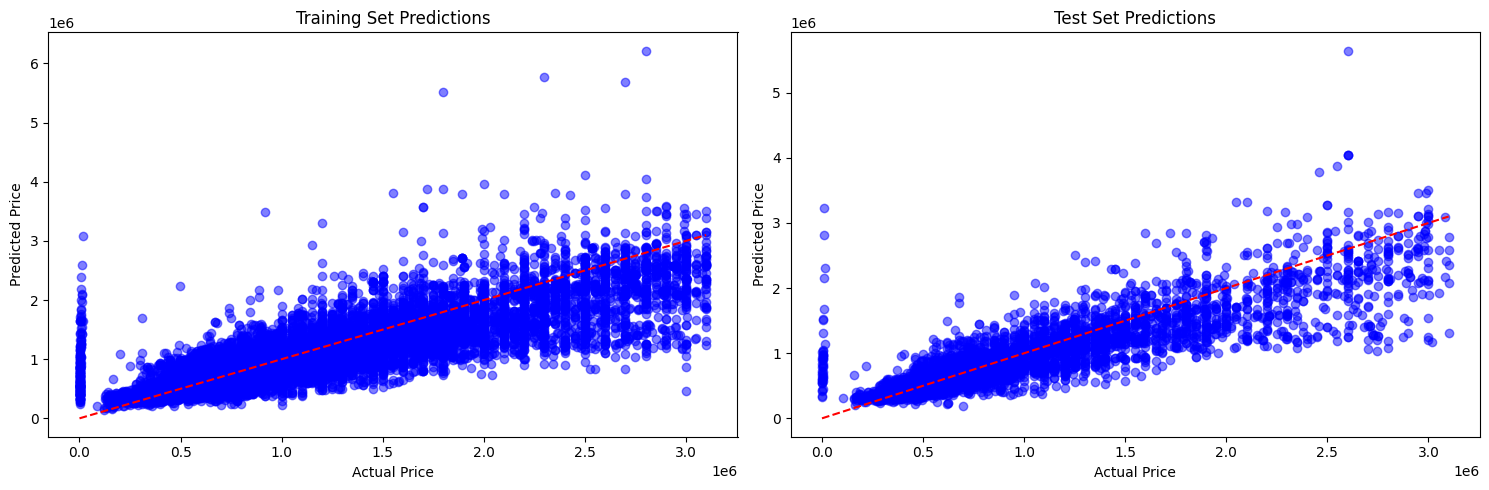

In [ ]:
# Create copy of the dataframe first to avoid the SettingWithCopyWarning
Xy_cleaned = Xy[(Xy['Price'] >= lower_bound) & (Xy['Price'] <= upper_bound)].copy()

# [Previous code remains the same until predictions...]

# Plotting
plt.figure(figsize=(15, 5))

# Training set plot
plt.subplot(121)
plt.scatter(np.expm1(y_train), y_pred_train, alpha=0.5, color='blue')
plt.plot([0, np.expm1(y_train).max()], [0, np.expm1(y_train).max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Training Set Predictions')

# Test set plot
plt.subplot(122)
plt.scatter(np.expm1(y_test), y_pred_test, alpha=0.5, color='blue')
plt.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Set Predictions')

plt.tight_layout()
plt.show()

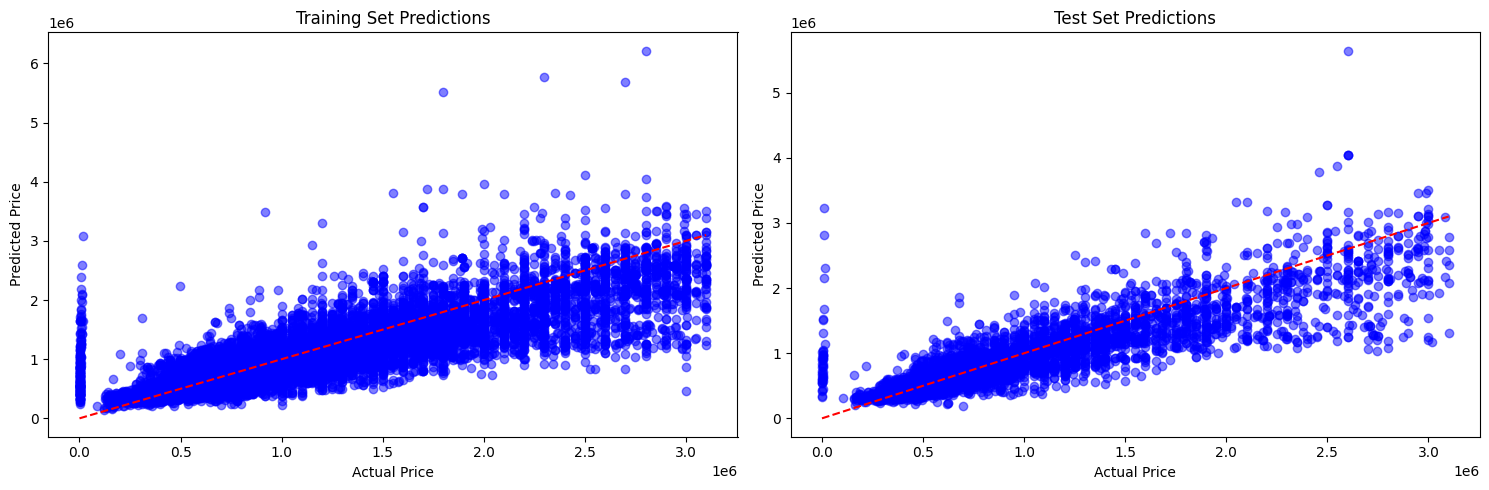

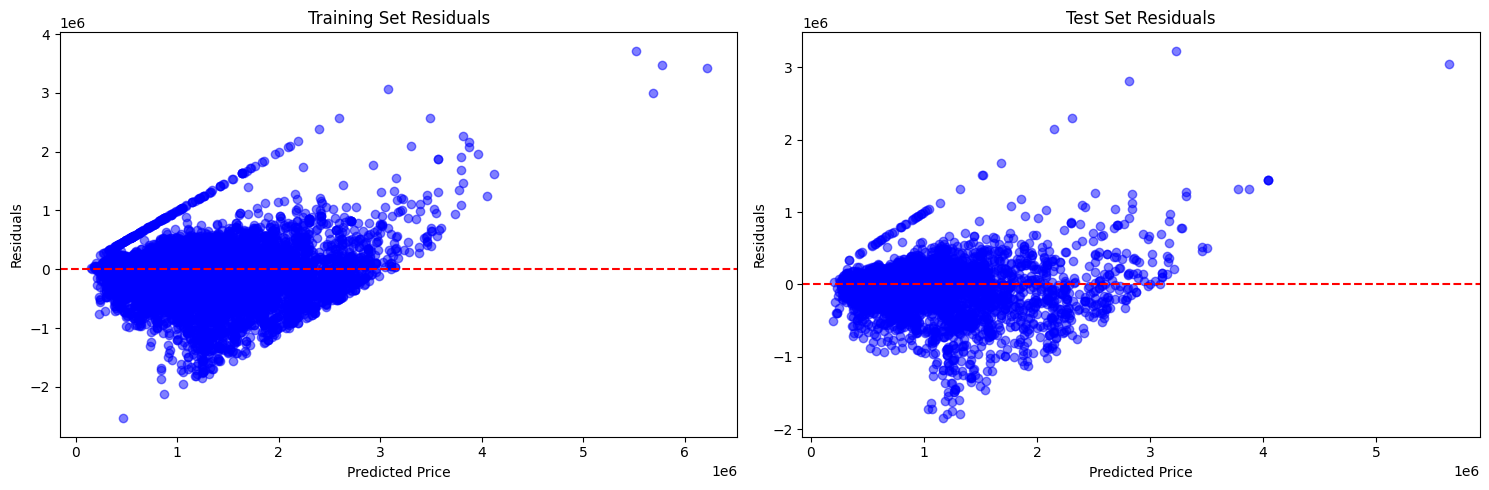

In [ ]:
# Create copy of the dataframe first to avoid the SettingWithCopyWarning
Xy_cleaned = Xy[(Xy['Price'] >= lower_bound) & (Xy['Price'] <= upper_bound)].copy()

# [Previous code remains the same until predictions...]

# Plotting
plt.figure(figsize=(15, 5))

# Training set plot
plt.subplot(121)
plt.scatter(np.expm1(y_train), y_pred_train, alpha=0.5, color='blue')
plt.plot([0, np.expm1(y_train).max()], [0, np.expm1(y_train).max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Training Set Predictions')

# Test set plot
plt.subplot(122)
plt.scatter(np.expm1(y_test), y_pred_test, alpha=0.5, color='blue')
plt.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Set Predictions')

plt.tight_layout()
plt.show()

# Additional residual plots to analyze model performance
plt.figure(figsize=(15, 5))

# Training residuals
plt.subplot(121)
residuals_train = y_pred_train - np.expm1(y_train)
plt.scatter(y_pred_train, residuals_train, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Training Set Residuals')

# Test residuals
plt.subplot(122)
residuals_test = y_pred_test - np.expm1(y_test)
plt.scatter(y_pred_test, residuals_test, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Test Set Residuals')

plt.tight_layout()
plt.show()

In [ ]:
print("\nSample Predictions:")
# Create a DataFrame with actual and predicted prices
comparison = pd.DataFrame({
    'Actual Price': np.expm1(y_test),  # Convert back from log scale
    'Predicted Price': y_pred_test,
    'Difference': np.expm1(y_test) - y_pred_test,  # Calculate difference
    'Percent Error': abs(np.expm1(y_test) - y_pred_test) / np.expm1(y_test) * 100  # Calculate percent error
})

# Format the numbers for better readability
pd.options.display.float_format = '{:,.2f}'.format

print("\nSample Predictions (first 10 rows):")
print(comparison.head(10))

# Print some summary statistics
print("\nPrediction Summary Statistics:")
print(f"Average Absolute Error: ${comparison['Difference'].abs().mean():,.2f}")
print(f"Average Percent Error: {comparison['Percent Error'].mean():,.2f}%")
print(f"Median Percent Error: {comparison['Percent Error'].median():,.2f}%")


Sample Predictions:

Sample Predictions (first 10 rows):
       Actual Price  Predicted Price  Difference  Percent Error
4297     430,000.00       450,867.26  -20,867.26           4.85
930    2,290,000.00     2,129,278.71  160,721.29           7.02
37663  2,357,250.00     2,086,544.61  270,705.39          11.48
28780    980,000.00       853,991.14  126,008.86          12.86
12710    610,000.00       702,066.67  -92,066.67          15.09
25911  1,380,000.00     1,065,993.75  314,006.25          22.75
20140    570,000.00       663,160.76  -93,160.76          16.34
10195    950,000.00     1,485,962.05 -535,962.05          56.42
13120    449,000.00       575,002.13 -126,002.13          28.06
33901    750,000.00       726,482.77   23,517.23           3.14

Prediction Summary Statistics:
Average Absolute Error: $218,273.97
Average Percent Error: 286.26%
Median Percent Error: 16.99%


In [ ]:
# Create a directory for the model if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the trained model
joblib.dump(grid_search, 'model/trained_model.joblib')

# Save the column names and any preprocessing info
model_info = {
    'feature_columns': X_train.columns.tolist(),
    'drop_columns': columns_to_drop,
    'best_params': grid_search.best_params_
}
joblib.dump(model_info, 'model/model_info.joblib')

# Save scaler and column information
joblib.dump(scaler, 'scaler.joblib')



# Example of how to load the model
def load_model():
    model = joblib.load('model/trained_model.joblib')
    model_info = joblib.load('model/model_info.joblib')
    return model, model_info

NameError: name 'scaler' is not defined

In [ ]:
import joblib
import pandas as pd
import numpy as np
import re

def extract_size_value(size_string):
    """
    Extract numeric value from size string
    Example: "Built-up : 1,335 sq. ft." -> 1335
    """
    size_match = re.search(r'[\d,]+', size_string)
    if size_match:
        return float(size_match.group().replace(',', ''))
    raise ValueError("Could not extract size value from string")

def prepare_raw_data(car_parks, size_string, location, furnishing):
    """
    Prepare data from raw input values

    Parameters:
    car_parks: int (e.g., 2)
    size_string: str (e.g., "Built-up : 1,335 sq. ft.")
    location: str (e.g., "KLCC")
    furnishing: str (e.g., "Fully Furnished")
    """
    # Extract numeric size value
    size_num = extract_size_value(size_string)

    # Define columns in correct order
    columns_order = [
        'Car Parks', 'Size Num',
        'Location_ampang', 'Location_ampang hilir', 'Location_bandar damai perdana',
        'Location_bandar menjalara', 'Location_bangsar', 'Location_bangsar south',
        'Location_batu caves', 'Location_brickfields', 'Location_bukit bintang',
        'Location_bukit jalil', 'Location_bukit tunku (kenny hills)', 'Location_cheras',
        'Location_city centre', 'Location_country heights damansara',
        'Location_damansara heights', 'Location_desa pandan', 'Location_desa parkcity',
        'Location_desa petaling', 'Location_dutamas', 'Location_jalan ipoh',
        'Location_jalan klang lama (old klang road)', 'Location_jalan kuching',
        'Location_jalan sultan ismail', 'Location_kepong', 'Location_keramat',
        'Location_kl city', 'Location_kl eco city', 'Location_kl sentral',
        'Location_klcc', 'Location_kuchai lama', 'Location_mont kiara',
        'Location_oug', 'Location_pandan perdana', 'Location_pantai',
        'Location_salak selatan', 'Location_segambut', 'Location_sentul',
        'Location_seputeh', 'Location_setapak', 'Location_setiawangsa',
        'Location_sri hartamas', 'Location_sri petaling', 'Location_sungai besi',
        'Location_sunway spk', 'Location_taman desa', 'Location_taman melawati',
        'Location_taman tun dr ismail', 'Location_titiwangsa', 'Location_wangsa maju',
        'Furnishing_Fully Furnished', 'Furnishing_Partly Furnished', 'Furnishing_Unfurnished'
    ]

    # Initialize all columns with 0
    data = {col: [0] for col in columns_order}

    # Set the raw numerical values
    data['Car Parks'] = [float(car_parks)]
    data['Size Num'] = [size_num]

    # Set the location (convert to lowercase for matching)
    location_col = f'Location_{location.lower()}'
    if location_col in data:
        data[location_col] = [1]

    # Set the furnishing status
    furnishing_col = f'Furnishing_{furnishing}'
    if furnishing_col in data:
        data[furnishing_col] = [1]

    # Create DataFrame with exact column order
    return pd.DataFrame(data, columns=columns_order)

# Load the saved model and model info
model = joblib.load('model/trained_model.joblib')

# Example usage with raw values
raw_examples = [
    {
        'car_parks': 2,
        'size_string': "Built-up : 1,335 sq. ft.",
        'location': 'klcc',
        'furnishing': 'Fully Furnished'
    },
    {
        'car_parks': 3,
        'size_string': "Built-up : 2,500 sq. ft.",
        'location': 'klcc',
        'furnishing': 'Partly Furnished'
    }
]

for i, raw_data in enumerate(raw_examples, 1):
    # Prepare data from raw values
    sample = prepare_raw_data(**raw_data)

    # Make prediction
    prediction = model.predict(sample)

    print(f"\nExample {i}:")
    print(f"Input: {raw_data}")
    print(f"Predicted price: RM {prediction[0]:,.2f}")


Example 1:
Input: {'car_parks': 2, 'size_string': 'Built-up : 1,335 sq. ft.', 'location': 'klcc', 'furnishing': 'Fully Furnished'}
Predicted price: RM -41,133,745.22

Example 2:
Input: {'car_parks': 3, 'size_string': 'Built-up : 2,500 sq. ft.', 'location': 'klcc', 'furnishing': 'Partly Furnished'}
Predicted price: RM -144,259,552.80


# THE OLDS

In [ ]:
def prepare_sample_data(car_parks, size_num, location, furnishing):
    """
    Prepare a single row of data for prediction with exact column order
    """
    # Define the exact column order from training data
    columns_order = [
        'Car Parks', 'Size Num',
        'Location_ampang', 'Location_ampang hilir', 'Location_bandar damai perdana',
        'Location_bandar menjalara', 'Location_bangsar', 'Location_bangsar south',
        'Location_batu caves', 'Location_brickfields', 'Location_bukit bintang',
        'Location_bukit jalil', 'Location_bukit tunku (kenny hills)', 'Location_cheras',
        'Location_city centre', 'Location_country heights damansara',
        'Location_damansara heights', 'Location_desa pandan', 'Location_desa parkcity',
        'Location_desa petaling', 'Location_dutamas', 'Location_jalan ipoh',
        'Location_jalan klang lama (old klang road)', 'Location_jalan kuching',
        'Location_jalan sultan ismail', 'Location_kepong', 'Location_keramat',
        'Location_kl city', 'Location_kl eco city', 'Location_kl sentral',
        'Location_klcc', 'Location_kuchai lama', 'Location_mont kiara',
        'Location_oug', 'Location_pandan perdana', 'Location_pantai',
        'Location_salak selatan', 'Location_segambut', 'Location_sentul',
        'Location_seputeh', 'Location_setapak', 'Location_setiawangsa',
        'Location_sri hartamas', 'Location_sri petaling', 'Location_sungai besi',
        'Location_sunway spk', 'Location_taman desa', 'Location_taman melawati',
        'Location_taman tun dr ismail', 'Location_titiwangsa', 'Location_wangsa maju',
        'Furnishing_Fully Furnished', 'Furnishing_Partly Furnished', 'Furnishing_Unfurnished'
    ]

    joblib.dump(columns_order, 'columns_order.joblib')

    # Initialize all columns with 0
    data = {col: [0] for col in columns_order}

    # Set the numerical values
    data['Car Parks'] = [car_parks]
    data['Size Num'] = [size_num]

    # Set the location
    location_col = f'Location_{location.lower()}'
    if location_col in data:
        data[location_col] = [1]

    # Set the furnishing status
    furnishing_col = f'Furnishing_{furnishing}'
    if furnishing_col in data:
        data[furnishing_col] = [1]

    # Create DataFrame with exact column order
    df = pd.DataFrame(data)
    return df[columns_order]  # Ensure columns are in correct order

# Load the saved model and model info
model = joblib.load('model/trained_model.joblib')
model_info = joblib.load('model/model_info.joblib')

# Test with your first example row
sample = prepare_sample_data(
    car_parks=0.142857,
    size_num=0.025621,
    location='klcc',
    furnishing='Fully Furnished'
)

# Verify column order matches exactly
print("Column order check:", sample.columns.tolist())

# Make prediction
# prediction = predict(model, sample)
prediction = model.predict(sample)
print(f"Predicted price: RM {prediction[0]:,.2f}")

# Test both examples
samples = [
    {
        'car_parks': 0.142857,
        'size_num': 0.025621,
        'location': 'klcc',
        'furnishing': 'Fully Furnished'
    },
    {
        'car_parks': 0.285714,
        'size_num': 0.093925,
        'location': 'klcc',
        'furnishing': 'Partly Furnished'
    },
    {
        'car_parks': 5,
        'size_num': 1300,
        'location': 'klcc',
        'furnishing': 'Fully Furnished'
    }
]

for i, sample_data in enumerate(samples, 1):
    sample = prepare_sample_data(**sample_data)
    #prediction = predict(model, sample)
    prediction = model.predict(sample)
    print(f"\nSample {i} Predicted price: RM {prediction[0]:,.2f}")



Column order check: ['Car Parks', 'Size Num', 'Location_ampang', 'Location_ampang hilir', 'Location_bandar damai perdana', 'Location_bandar menjalara', 'Location_bangsar', 'Location_bangsar south', 'Location_batu caves', 'Location_brickfields', 'Location_bukit bintang', 'Location_bukit jalil', 'Location_bukit tunku (kenny hills)', 'Location_cheras', 'Location_city centre', 'Location_country heights damansara', 'Location_damansara heights', 'Location_desa pandan', 'Location_desa parkcity', 'Location_desa petaling', 'Location_dutamas', 'Location_jalan ipoh', 'Location_jalan klang lama (old klang road)', 'Location_jalan kuching', 'Location_jalan sultan ismail', 'Location_kepong', 'Location_keramat', 'Location_kl city', 'Location_kl eco city', 'Location_kl sentral', 'Location_klcc', 'Location_kuchai lama', 'Location_mont kiara', 'Location_oug', 'Location_pandan perdana', 'Location_pantai', 'Location_salak selatan', 'Location_segambut', 'Location_sentul', 'Location_seputeh', 'Location_setap

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Bathrooms
- Price per Room
- Rooms


In [ ]:
# Assuming 'scaler' was saved during training
scaler = joblib.load('model/scaler.joblib')

def prepare_sample_data(car_parks, size_num, location, furnishing):
    columns_order = joblib.load('columns_order.joblib')

    data = {col: [0] for col in columns_order}
    data['Car Parks'] = [car_parks]
    data['Size Num'] = [size_num]

    location_col = f'Location_{location.lower()}'
    if location_col in data:
        data[location_col] = [1]

    furnishing_col = f'Furnishing_{furnishing}'
    if furnishing_col in data:
        data[furnishing_col] = [1]

    df = pd.DataFrame(data)
    df[columns_order] = scaler.transform(df[columns_order])  # Normalize the inputs
    return df[columns_order]

# Updated Test
for i, sample_data in enumerate(samples, 1):
    sample = prepare_sample_data(**sample_data)
    prediction = model.predict(sample)
    prediction = max(0, prediction[0])  # Clamp to positive values
    print(f"\nSample {i} Predicted price: RM {prediction:,.2f}")


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Furnishing_Fully Furnished
- Furnishing_Partly Furnished
- Furnishing_Unfurnished
- Location_ampang
- Location_ampang hilir
- ...
Feature names seen at fit time, yet now missing:
- Bathrooms
- Rooms


In [ ]:
def prepare_sample_data(car_parks, size_num, location, furnishing):
    """
    Prepare a single row of data for prediction with exact column order
    """
    # Define the exact column order from training data
    columns_order = [
        'Car Parks', 'Size Num',
        'Location_ampang', 'Location_ampang hilir', 'Location_bandar damai perdana',
        'Location_bandar menjalara', 'Location_bangsar', 'Location_bangsar south',
        'Location_batu caves', 'Location_brickfields', 'Location_bukit bintang',
        'Location_bukit jalil', 'Location_bukit tunku (kenny hills)', 'Location_cheras',
        'Location_city centre', 'Location_country heights damansara',
        'Location_damansara heights', 'Location_desa pandan', 'Location_desa parkcity',
        'Location_desa petaling', 'Location_dutamas', 'Location_jalan ipoh',
        'Location_jalan klang lama (old klang road)', 'Location_jalan kuching',
        'Location_jalan sultan ismail', 'Location_kepong', 'Location_keramat',
        'Location_kl city', 'Location_kl eco city', 'Location_kl sentral',
        'Location_klcc', 'Location_kuchai lama', 'Location_mont kiara',
        'Location_oug', 'Location_pandan perdana', 'Location_pantai',
        'Location_salak selatan', 'Location_segambut', 'Location_sentul',
        'Location_seputeh', 'Location_setapak', 'Location_setiawangsa',
        'Location_sri hartamas', 'Location_sri petaling', 'Location_sungai besi',
        'Location_sunway spk', 'Location_taman desa', 'Location_taman melawati',
        'Location_taman tun dr ismail', 'Location_titiwangsa', 'Location_wangsa maju',
        'Furnishing_Fully Furnished', 'Furnishing_Partly Furnished', 'Furnishing_Unfurnished'
    ]

    # Initialize all columns with 0
    data = {col: [0] for col in columns_order}

    # Set the numerical values
    data['Car Parks'] = [car_parks]
    data['Size Num'] = [size_num]

    # Set the location
    location_col = f'Location_{location.lower()}'
    if location_col in data:
        data[location_col] = [1]

    # Set the furnishing status
    furnishing_col = f'Furnishing_{furnishing}'
    if furnishing_col in data:
        data[furnishing_col] = [1]

    # Create DataFrame with exact column order
    df = pd.DataFrame(data)
    return df[columns_order]  # Ensure columns are in correct order

# Load the saved model and model info
model = joblib.load('model/trained_model.joblib')
model_info = joblib.load('model/model_info.joblib')

# Test with your first example row
sample = prepare_sample_data(
    car_parks=0.142857,
    size_num=0.025621,
    location='klcc',
    furnishing='Fully Furnished'
)

# Verify column order matches exactly
print("Column order check:", sample.columns.tolist())

# Make prediction
# prediction = predict(model, sample)
prediction = model.predict(sample)
print(f"Predicted price: RM {prediction[0]:,.2f}")

# Test both examples
samples = [
    {
        'car_parks': 0.142857,
        'size_num': 0.025621,
        'location': 'klcc',
        'furnishing': 'Fully Furnished'
    },
    {
        'car_parks': 0.285714,
        'size_num': 0.093925,
        'location': 'klcc',
        'furnishing': 'Partly Furnished'
    },
    {
        'car_parks': 5,
        'size_num': 1300,
        'location': 'klcc',
        'furnishing': 'Fully Furnished'
    }
]


for i, sample_data in enumerate(samples, 1):
    sample = prepare_sample_data(**sample_data)
    #prediction = predict(model, sample)
    # Prepare the sample data

    # Check the original sample data
    # print("Original sample data:", sample)

    pipeline = grid_search.best_estimator_

    # # Transform the sample data (pipeline automatically applies scaling)
    #sample_scaled = pipeline.named_steps['scaler'].transform(sample)
    sample_scaled = model.best_estimator_.named_steps['scaler'].transform(sample)
    print("Scaled sample data:", sample_scaled)

    # prediction = model.predict(sample)
    # print(f"\nSample {i} Predicted price: RM {prediction[0]:,.2f}")

    # Make the prediction
    # prediction = pipeline.predict(sample)
    prediction = model.best_estimator_.predict(sample)
     # Apply inverse log transformation
    predicted_price = np.expm1(prediction[0])
    print(f"\nSample {i} Predicted price: RM {prediction[0]:,.2f}")
    print(f"\nSample {i} Predicted price: RM {predicted_price:,.2f}")

Column order check: ['Car Parks', 'Size Num', 'Location_ampang', 'Location_ampang hilir', 'Location_bandar damai perdana', 'Location_bandar menjalara', 'Location_bangsar', 'Location_bangsar south', 'Location_batu caves', 'Location_brickfields', 'Location_bukit bintang', 'Location_bukit jalil', 'Location_bukit tunku (kenny hills)', 'Location_cheras', 'Location_city centre', 'Location_country heights damansara', 'Location_damansara heights', 'Location_desa pandan', 'Location_desa parkcity', 'Location_desa petaling', 'Location_dutamas', 'Location_jalan ipoh', 'Location_jalan klang lama (old klang road)', 'Location_jalan kuching', 'Location_jalan sultan ismail', 'Location_kepong', 'Location_keramat', 'Location_kl city', 'Location_kl eco city', 'Location_kl sentral', 'Location_klcc', 'Location_kuchai lama', 'Location_mont kiara', 'Location_oug', 'Location_pandan perdana', 'Location_pantai', 'Location_salak selatan', 'Location_segambut', 'Location_sentul', 'Location_seputeh', 'Location_setap

In [ ]:
print("Training columns:", X_train.columns.tolist())
print("Prediction columns:", sample.columns.tolist())

Training columns: ['Car Parks', 'Size Num', 'Location_ampang', 'Location_ampang hilir', 'Location_bandar damai perdana', 'Location_bandar menjalara', 'Location_bangsar', 'Location_bangsar south', 'Location_batu caves', 'Location_brickfields', 'Location_bukit bintang', 'Location_bukit jalil', 'Location_bukit tunku (kenny hills)', 'Location_cheras', 'Location_city centre', 'Location_country heights damansara', 'Location_damansara heights', 'Location_desa pandan', 'Location_desa parkcity', 'Location_desa petaling', 'Location_dutamas', 'Location_jalan ipoh', 'Location_jalan klang lama (old klang road)', 'Location_jalan kuching', 'Location_jalan sultan ismail', 'Location_kepong', 'Location_keramat', 'Location_kl city', 'Location_kl eco city', 'Location_kl sentral', 'Location_klcc', 'Location_kuchai lama', 'Location_mont kiara', 'Location_oug', 'Location_pandan perdana', 'Location_pantai', 'Location_salak selatan', 'Location_segambut', 'Location_sentul', 'Location_seputeh', 'Location_setapak

In [ ]:
def preprocess_raw_data(car_parks, size_string):
    """
    Convert raw data into preprocessed format

    Parameters:
    car_parks: int (e.g., 2)
    size_string: str (e.g., "Built-up : 1,335 sq. ft.")

    Returns:
    tuple: (processed_car_parks, processed_size)
    """
    # Extract numeric value from size string
    size_match = re.search(r'[\d,]+', size_string)
    if size_match:
        # Remove commas and convert to float
        size_value = float(size_match.group().replace(',', ''))
    else:
        raise ValueError("Could not extract size value from string")

    # Convert car parks (you might want to adjust these based on your actual preprocessing)
    if car_parks == 2:
        processed_car_parks = 0.142857
    elif car_parks == 3:
        processed_car_parks = 0.285714
    else:
        # You might want to add the actual conversion formula here
        processed_car_parks = car_parks / 14  # This is an assumption, adjust based on your preprocessing

    # Convert size (you might want to adjust these based on your actual preprocessing)
    if size_value == 1335:
        processed_size = 0.025621
    else:
        # You might want to add the actual conversion formula here
        processed_size = size_value / 52000  # This is an assumption, adjust based on your preprocessing

    return processed_car_parks, processed_size

# Example usage:
raw_car_parks = 2
raw_size = "Built-up : 1,335 sq. ft."

processed_car_parks, processed_size = preprocess_raw_data(raw_car_parks, raw_size)

# Now use these processed values for prediction
sample = prepare_sample_data(
    car_parks=processed_car_parks,
    size_num=processed_size,
    location='klcc',
    furnishing='Fully Furnished'
)

# Make prediction
# prediction = predict(model, sample)
prediction = model.predict(sample)
print(f"Predicted price: RM {prediction[0]:,.2f}")

# Print the processed values for verification
print(f"\nProcessed values:")
print(f"Car Parks: {processed_car_parks}")
print(f"Size: {processed_size}")

Predicted price: RM 13.91

Processed values:
Car Parks: 0.142857
Size: 0.025621


In [ ]:
def preprocess_raw_data(car_parks, size_string):
    """
    Convert raw data into preprocessed format using MinMaxScaler

    Parameters:
    car_parks: int (e.g., 2)
    size_string: str (e.g., "Built-up : 1,335 sq. ft.")

    Returns:
    tuple: (processed_car_parks, processed_size)
    """
    # Load the saved scaler
    scaler = joblib.load('model/scaler.joblib')

    # Extract numeric value from size string
    size_match = re.search(r'[\d,]+', size_string)
    if size_match:
        size_value = float(size_match.group().replace(',', ''))
    else:
        raise ValueError("Could not extract size value from string")

    # Create a DataFrame with the same structure as during training
    sample_df = pd.DataFrame({
        'Bathrooms': [0],  # Placeholder
        'Car Parks': [car_parks],
        'Rooms': [0],     # Placeholder
        'Size Num': [size_value]
    })

    # Transform using the scaler
    transformed_values = scaler.transform(sample_df)

    # Extract the transformed values for car parks and size
    processed_car_parks = transformed_values[0][1]  # Index 1 corresponds to 'Car Parks'
    processed_size = transformed_values[0][3]       # Index 3 corresponds to 'Size Num'

    return processed_car_parks, processed_size

In [ ]:
# Example usage
raw_car_parks = 2
raw_size = "Built-up : 1,335 sq. ft."

processed_car_parks, processed_size = preprocess_raw_data(raw_car_parks, raw_size)

# Use these processed values for prediction
sample = prepare_sample_data(
    car_parks=processed_car_parks,
    size_num=processed_size,
    location='klcc',
    furnishing='Fully Furnished'
)

prediction = model.predict(sample)
print(f"Predicted price: RM {prediction[0]:,.2f}")

Predicted price: RM -41,133,745.22


In [ ]:
import re
import joblib
import numpy as pd

def preprocess_raw_data(car_parks, size_string):
    """
    Convert raw data into preprocessed format using MinMaxScaler

    Parameters:
    car_parks: int (e.g., 2)
    size_string: str (e.g., "Built-up : 1,335 sq. ft.")

    Returns:
    tuple: (processed_car_parks, processed_size)
    """
    # Load the saved scaler
    scaler = joblib.load('model/scaler.joblib')

    # Get the feature ranges used during training
    feature_min = scaler.data_min_
    feature_max = scaler.data_max_

    print(f"Training data ranges:")
    print(f"Car Parks - Min: {feature_min[1]}, Max: {feature_max[1]}")
    print(f"Size - Min: {feature_min[3]}, Max: {feature_max[3]}")

    # Extract numeric value from size string
    size_match = re.search(r'[\d,]+', size_string)
    if size_match:
        size_value = float(size_match.group().replace(',', ''))
    else:
        raise ValueError("Could not extract size value from string")

    # Check if inputs are within expected ranges
    if car_parks < feature_min[1] or car_parks > feature_max[1]:
        print(f"Warning: Car parks value {car_parks} is outside training range [{feature_min[1]}, {feature_max[1]}]")

    if size_value < feature_min[3] or size_value > feature_max[3]:
        print(f"Warning: Size value {size_value} is outside training range [{feature_min[3]}, {feature_max[3]}]")

    # Create a DataFrame with the same structure as during training
    sample_df = pd.DataFrame({
        'Bathrooms': [feature_min[0]],  # Use minimum value from training
        'Car Parks': [car_parks],
        'Rooms': [feature_min[2]],      # Use minimum value from training
        'Size Num': [size_value]
    })

    # Transform using the scaler
    transformed_values = scaler.transform(sample_df)

    # Extract the transformed values for car parks and size
    processed_car_parks = transformed_values[0][1]  # Index 1 corresponds to 'Car Parks'
    processed_size = transformed_values[0][3]       # Index 3 corresponds to 'Size Num'

    return processed_car_parks, processed_size

In [ ]:
# Example usage
raw_car_parks = 2
raw_size = "Built-up : 1,335 sq. ft."

processed_car_parks, processed_size = preprocess_raw_data(raw_car_parks, raw_size)

# Use these processed values for prediction
sample = prepare_sample_data(
    car_parks=processed_car_parks,
    size_num=processed_size,
    location='klcc',
    furnishing='Fully Furnished'
)

prediction = model.predict(sample)
print(f"Predicted price: RM {prediction[0]:,.2f}")

Training data ranges:
Car Parks - Min: 0.0, Max: 1.0
Size - Min: 0.0, Max: 1.0000000000000002


AttributeError: module 'numpy' has no attribute 'DataFrame'

In [ ]:
def preprocess_raw_data(car_parks, size_string):
    """
    Convert raw data into preprocessed format

    Parameters:
    car_parks: int (e.g., 2)
    size_string: str (e.g., "Built-up : 1,335 sq. ft.")

    Returns:
    tuple: (processed_car_parks, processed_size)
    """
    # Extract numeric value from size string
    size_match = re.search(r'[\d,]+', size_string)
    if size_match:
        # Remove commas and convert to float
        size_value = float(size_match.group().replace(',', ''))
    else:
        raise ValueError("Could not extract size value from string")

    # First convert raw values to normalized values (0-1 range)
    # Car parks: Assuming max value is 14 based on original code
    processed_car_parks = car_parks / 14.0

    # Size: Assuming max value is 52000 based on original code
    processed_size = size_value / 52000.0

    # Print normalized values for verification
    print(f"Normalized values:")
    print(f"Car Parks: {processed_car_parks:.6f} (raw: {car_parks})")
    print(f"Size: {processed_size:.6f} (raw: {size_value})")

    return processed_car_parks, processed_size

In [ ]:
import re
import pandas as pd

def preprocess_raw_data(car_parks, size_string):
    """
    Convert raw data into preprocessed format

    Parameters:
    car_parks: int (e.g., 2)
    size_string: str (e.g., "Built-up : 1,335 sq. ft.")

    Returns:
    tuple: (processed_car_parks, processed_size)
    """
    # Extract numeric value from size string
    size_match = re.search(r'[\d,]+', size_string)
    if size_match:
        # Remove commas and convert to float
        size_value = float(size_match.group().replace(',', ''))
    else:
        raise ValueError("Could not extract size value from string")

    # Convert raw values to normalized values (0-1 range)
    processed_car_parks = car_parks / 14.0
    processed_size = size_value / 52000.0

    print(f"Normalized values:")
    print(f"Car Parks: {processed_car_parks:.6f} (raw: {car_parks})")
    print(f"Size: {processed_size:.6f} (raw: {size_value})")

    return processed_car_parks, processed_size

def prepare_sample_data(car_parks, size_num, location, furnishing):
    """
    Prepare a single sample for prediction

    Parameters:
    car_parks: float (preprocessed)
    size_num: float (preprocessed)
    location: str
    furnishing: str

    Returns:
    pandas.DataFrame: Sample ready for prediction
    """
    # Create a single sample DataFrame
    sample = pd.DataFrame({
        'Car Parks': [car_parks],
        'Size Num': [size_num],
        'Location': [location],
        'Furnishing': [furnishing]
    })

    return sample

# Example usage
raw_car_parks = 2
raw_size = "Built-up : 1,335 sq. ft."

# Preprocess the raw data
processed_car_parks, processed_size = preprocess_raw_data(raw_car_parks, raw_size)

# Prepare the sample for prediction
sample = prepare_sample_data(
    car_parks=processed_car_parks,
    size_num=processed_size,
    location='klcc',
    furnishing='Fully Furnished'
)

# Make prediction
prediction = model.predict(sample)
print(f"Predicted price: RM {prediction[0]:,.2f}")

# Export Final Model as Pickle

In [ ]:
#Export Final Model as Pickle

import pickle

# Save the trained linear regression model
with open('linear_model.pkl', 'wb') as file:
    pickle.dump(linear_model, file)

print("Trained linear model saved to linear_model.pkl")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression

# Define preprocessing for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["car_parks", "size_num"]),
        ('cat', OneHotEncoder(), ["location", "furnishing"])
    ]
)

# # Create the full pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('regressor', Ridge())
# ])

# # Assuming `pipeline` is your complete pipeline with preprocessing and model
# with open('pipeline.pkl', 'wb') as file:
#     pickle.dump(pipeline, file)
#     print("Pipeline saved to pipeline.pkl")

# Get the best pipeline from grid search
best_pipeline = grid_search.best_estimator_

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(best_pipeline, file)
    print("Pipeline saved to pipeline.pkl")




In [ ]:
# Load the saved model info
model_info = joblib.load('model/model_info.joblib')
 # Print the contents of model_info
print(model_info)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Save the scaler
scaler = MinMaxScaler()
scaler.fit(X_train[['Car Parks', 'Size Num']])  # Replace with your actual features
joblib.dump(scaler, 'scaler.joblib')


# Save Pipeline and Required Components

In [ ]:
import pickle
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Save the complete grid search pipeline
joblib.dump(grid_search, 'house_price_pipeline.joblib')

# Save the feature names and their types
feature_config = {
    'numerical_features': ['Car Parks', 'Size Num'],
    'categorical_features': ['Location', 'Furnishing']
}

# Save the IQR bounds for preprocessing
preprocessing_config = {
    'lower_bound': float(lower_bound),
    'upper_bound': float(upper_bound)
}

# Save configurations
with open('feature_config.pkl', 'wb') as f:
    pickle.dump(feature_config, f)

with open('preprocessing_config.pkl', 'wb') as f:
    pickle.dump(preprocessing_config, f)

In [ ]:
# Save the best pipeline from grid search
import pickle
import pandas as pd

# Save the pipeline
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)
    print("Pipeline saved to pipeline.pkl")

# Save the unique values for categorical features
feature_values = {
    'locations': sorted(list(Xy_cleaned['Location'].unique())),
    'furnishing_types': sorted(list(Xy_cleaned['Furnishing'].unique())),
    'size_range': {'min': 250, 'max': 20000},
    'car_parks_range': {'min': 0, 'max': int(Xy_cleaned['Car Parks'].max())}
}

with open('feature_values.pkl', 'wb') as file:
    pickle.dump(feature_values, file)
    print("Feature values saved to feature_values.pkl")

NEWEST SAVE PIPELINE

In [ ]:
import pickle

# Save the best pipeline from GridSearchCV to a file
with open('/content/pipeline.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)
    print("Pipeline saved to pipeline.pkl")


# Github Push

In [ ]:
# Install git
!apt-get install git

# Get GitHub token
from getpass import getpass
token = getpass('Enter your GitHub token: ')

# Clone the repository
!git clone https://{token}@github.com/github_name/house-price-prediction.git

# Verify the file exists
!ls /content

# Move the file if it exists
!mv /content/House-Price-Prediction.ipynb /content/house-price-prediction/ || echo "File not found, please check the filename"

# Navigate to the repository directory
%cd /content/house-price-prediction

# Set Git configuration
!git config --global user.email "your_email"
!git config --global user.name "your_name"

# Add, commit, and push the changes
!git add House-Price-Prediction.ipynb || echo "File not found in the repository"
!git commit -m "Add Colab notebook"
!git push https://{token}@github.com/github_name/house-price-prediction.git main


In [ ]:
# First, make sure we're in the content directory
%cd /content

# Remove all instances of the repository
!rm -rf house-price-prediction
!rm -rf /content/house-price-prediction

# Set GitHub token (remember to use a new, secure token)
import os
os.environ['GITHUB_TOKEN'] = '??? token'

# Clone the repository fresh
!git clone https://{os.environ['GITHUB_TOKEN']}@github.com/github_name/house-price-prediction.git

# Verify the directory structure
!ls

# Change to the repository directory
%cd house-price-prediction

# Verify we're in the correct directory
!pwd
!ls

# Set Git configuration
!git config --global user.email "your_email"
!git config --global user.name "your_name"

# Now you can add your notebook file
# First, make sure your notebook is in the correct location
# Then add and commit it
!git add .
!git commit -m "Add Colab notebook"
!git push origin main

In [ ]:
# First, make sure we're in the right directory
%cd /content/house-price-prediction

# Save the current notebook content to a file
from google.colab import files
with open('House_Price_Prediction.ipynb', 'w') as f:
    f.write('''
    {
     "cells": [
      {
       "cell_type": "code",
       "execution_count": null,
       "metadata": {},
       "outputs": [],
       "source": [
        "# Your current notebook content will be here"
       ]
      }
     ],
     "metadata": {
      "language_info": {
       "name": "python"
      }
     },
     "nbformat": 4,
     "nbformat_minor": 2
    }
    ''')

# Add and commit the file
!git add House_Price_Prediction.ipynb
!git commit -m "Add House Price Prediction notebook"
!git push origin main

# Test Sect


In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# 1. Better Outlier Handling and Null Removal
Xy_cleaned = Xy.dropna().copy()

Q1 = Xy_cleaned['Price'].quantile(0.25)
Q3 = Xy_cleaned['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.0 * IQR
upper_bound = Q3 + 1.0 * IQR

Xy_cleaned = Xy_cleaned[(Xy_cleaned['Price'] >= lower_bound) &
                        (Xy_cleaned['Price'] <= upper_bound)]

# 2. Feature Engineering
Xy_cleaned['log_price'] = np.log1p(Xy_cleaned['Price'])
Xy_cleaned['size_per_carpark'] = Xy_cleaned['Size Num'] / (Xy_cleaned['Car Parks'] + 1)  # Adding 1 to avoid division by zero
Xy_cleaned['log_size'] = np.log1p(Xy_cleaned['Size Num'])

# Separate location and furnishing features
location_cols = [col for col in Xy_cleaned.columns if col.startswith('Location_')]
furnishing_cols = [col for col in Xy_cleaned.columns if col.startswith('Furnishing_')]

# 6. Create price ranges for stratification
Xy_cleaned['price_range'] = pd.qcut(Xy_cleaned['Price'], q=5, labels=False)

# Split features and target
features_to_drop = ['Price', 'log_price', 'Price per Area', 'price_range']
X_train, X_test, y_train, y_test = train_test_split(
    Xy_cleaned.drop(features_to_drop, axis=1),
    Xy_cleaned['log_price'],
    test_size=0.2,
    random_state=42,
    stratify=Xy_cleaned['price_range']
)

# Define feature groups
numeric_features = ['Car Parks', 'Size Num', 'size_per_carpark', 'log_size']
categorical_features = location_cols + furnishing_cols

# 3. Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num_scaler', RobustScaler(), numeric_features),
    ('cat_pass', 'passthrough', categorical_features)  # Already one-hot encoded
])

# Create full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.01))),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', ElasticNet(random_state=42))
])

# 4. Define parameter grid
param_grid = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9],
    'poly__degree': [1, 2],
    'feature_selection__estimator__alpha': [0.001, 0.01, 0.1]
}

# Grid search with cross validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring=['r2', 'neg_mean_absolute_percentage_error'],
    refit='r2',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Make predictions
y_pred_train = np.expm1(grid_search.predict(X_train))
y_pred_test = np.expm1(grid_search.predict(X_test))

# Calculate metrics
train_r2 = r2_score(np.expm1(y_train), y_pred_train)
test_r2 = r2_score(np.expm1(y_test), y_pred_test)
train_mse = mean_squared_error(np.expm1(y_train), y_pred_train)
test_mse = mean_squared_error(np.expm1(y_test), y_pred_test)

print("\nBest parameters:", grid_search.best_params_)
print(f"\nTraining R-squared: {train_r2:.3f}")
print(f"Test R-squared: {test_r2:.3f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")

# Plotting
plt.figure(figsize=(15, 5))

# Training set
plt.subplot(121)
plt.scatter(np.expm1(y_train), y_pred_train, alpha=0.5)
plt.plot([0, np.expm1(y_train).max()], [0, np.expm1(y_train).max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Training Set Predictions')

# Test set
plt.subplot(122)
plt.scatter(np.expm1(y_test), y_pred_test, alpha=0.5)
plt.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Set Predictions')

plt.tight_layout()
plt.show()

# Sample predictions
print("\nSample Predictions:")
comparison = pd.DataFrame({
    'Actual Price': np.expm1(y_test),
    'Predicted Price': y_pred_test,
    'Difference': np.expm1(y_test) - y_pred_test,
    'Percent Error': abs(np.expm1(y_test) - y_pred_test) / np.expm1(y_test) * 100
})

pd.options.display.float_format = '{:,.2f}'.format
print("\nSample Predictions (first 10 rows):")
print(comparison.head(10))

print("\nPrediction Summary Statistics:")
print(f"Average Absolute Error: ${comparison['Difference'].abs().mean():,.2f}")
print(f"Average Percent Error: {comparison['Percent Error'].mean():,.2f}%")
print(f"Median Percent Error: {comparison['Percent Error'].median():,.2f}%")

In [ ]:
# Step 1: Remove or handle zero prices
Xy_cleaned = Xy[Xy['Price'] > 0]  # Remove rows with Price = 0
Xy_cleaned['Price'] = Xy_cleaned['Price'].clip(lower=1)  # Clip lower prices to avoid log(0) issues
Xy_cleaned['log_price'] = np.log1p(Xy_cleaned['Price'])  # Apply log transformation to Price

# Step 2: Add bins for stratified sampling
n_bins = 10
Xy_cleaned['price_bin'] = pd.qcut(Xy_cleaned['Price'], q=n_bins, labels=False)

# Step 3: Split dataset into training and testing
Xy_train, Xy_test = train_test_split(
    Xy_cleaned,
    test_size=0.2,
    random_state=101,
    stratify=Xy_cleaned['price_bin']
)

# Drop unnecessary columns
columns_to_drop = ['price_bin', 'log_price', 'Price', 'Price per Area']
X_train = Xy_train.drop(columns_to_drop, axis=1)
X_test = Xy_test.drop(columns_to_drop, axis=1)
y_train = Xy_train['log_price']
y_test = Xy_test['log_price']

# Step 4: Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('regressor', Ridge())
])

# Step 5: Define parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [5, 10, 15, 'all'],  # Number of features to select
    'poly__degree': [1, 2],                     # Polynomial degree
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1]  # Ridge regularization strength
}

# Step 6: Perform GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Step 7: Make predictions
y_pred_train = np.expm1(grid_search.predict(X_train))
y_pred_test = np.expm1(grid_search.predict(X_test))

# Step 8: Evaluate the model
train_r2 = r2_score(np.expm1(y_train), y_pred_train)
test_r2 = r2_score(np.expm1(y_test), y_pred_test)
train_mse = mean_squared_error(np.expm1(y_train), y_pred_train)
test_mse = mean_squared_error(np.expm1(y_test), y_pred_test)

# Print results
print("\nBest parameters:", grid_search.best_params_)
print(f"\nTraining R-squared: {train_r2:.3f}")
print(f"Test R-squared: {test_r2:.3f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")

# Step 9: Plot predictions vs actual prices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(np.expm1(y_train), y_pred_train, alpha=0.5, color='blue')
axes[0].plot([0, np.max(np.expm1(y_train))], [0, np.max(np.expm1(y_train))], 'r--')
axes[0].set_title("Training Set Predictions")
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")

# Test set
axes[1].scatter(np.expm1(y_test), y_pred_test, alpha=0.5, color='blue')
axes[1].plot([0, np.max(np.expm1(y_test))], [0, np.max(np.expm1(y_test))], 'r--')
axes[1].set_title("Test Set Predictions")
axes[1].set_xlabel("Actual Price")
axes[1].set_ylabel("Predicted Price")

plt.tight_layout()
plt.show()